# 0.0 Imports

In [44]:
import pandas     as pd
import numpy      as np 
import seaborn    as sns   
import scikitplot as skplt

from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestClassifier
from boruta                import BorutaPy    
from scipy                 import stats


from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib            import pyplot          as plt        
from sklearn               import preprocessing   as pp        
from sklearn               import model_selection as ms  
from sklearn               import ensemble        as en  
from sklearn               import neighbors       as nh
from sklearn               import linear_model    as lm

from sklearn.metrics         import precision_score, recall_score, accuracy_score,\
                                    balanced_accuracy_score,classification_report,roc_auc_score,\
                                    top_k_accuracy_score, roc_curve,auc,RocCurveDisplay,confusion_matrix


## 0.1. Helper Functions

In [42]:
def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

def cross_validation(model,x_train,y_train,k,Verbose=True):
    kfold = ms.StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    accuracy_balanced_list = []
    precision_k_list = [] 
    recall_k_list = []  
    auc_roc_list = []
    top_k_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        if Verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_proba = model.predict_proba(x_val_fold)

        # Create data to make the precision and recall k
        data = pd.DataFrame()
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        data = data.sort_values('score',ascending=False)
        
        knum = y_val_fold.value_counts().count()-1
        
        # ROC AUC SCORE
        auc_roc = roc_auc_score(y_val_fold, yhat_proba[:, 1])
        auc_roc_list.append(auc_roc)
        
        # TOP K SCORE
        top_k = top_k_accuracy_score(y_val_fold,yhat_model,k=knum)
        top_k_list.append(top_k)
        
        # Balanced Accuracy
        accuracy_balanced = balanced_accuracy_score(y_val_fold,yhat_model)
        accuracy_balanced_list.append(accuracy_balanced)
        
        # Precision at K
        precision_k = precision_at_k(data,20000)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data,20000)
        recall_k_list.append(recall_k)
        i = i + 1
        
    df = pd.DataFrame({'Model Name': type(model).__name__,
                       'Accuracy Balanced': np.round(np.mean(accuracy_balanced_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_balanced_list),4).astype(str),
                       'Precision @K Mean': np.round(np.mean(precision_k_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_k_list),4).astype(str),
                       'Recall @K Mean': np.round(np.mean(recall_k_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_k_list),4).astype(str),
                       'ROC AUC Score': np.round(np.mean(auc_roc_list),4).astype(str) + ' +/- ' + np.round(np.std(auc_roc_list),4).astype(str),
                       'Top K Score': np.round(np.mean(top_k_list),4).astype(str) + ' +/- ' + np.round(np.std(top_k_list),4).astype(str) },index = [0])
    return df

def precision_at_k(df8,k=20000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['precision_k'] = df8['response'].cumsum()/df8['ranking']

    return df8.loc[k,'precision_k']
    
def recall_at_k(df8,k=20000):
    #reset index
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall_k'] = df8['response'].cumsum()/df8['response'].sum()

    return df8.loc[k,'recall_k']

def gain(df8,yhat_et):

    #propensity score
    df8['score'] = yhat_et[:,1].tolist()

    #sorted by propensity score
    df8 = df8.sort_values('score',ascending=False)
    df8 = df8.reset_index(drop=True)

    #create ranking order
    df8['ranking'] = df8.index + 1 #Pra não começar do 0

    #cumsum - soma acumulada
    df8['recall'] = df8['response'].cumsum()/df8['response'].sum()
    df8['base_porcentage'] = df8['ranking']/df8.shape[0]
    
    return df8

#Definindo a função de cramer V
def cramer_v(x,y):
    """Função para executar o cálculo Cramer's V."""
    #Combinações entre as variáveis categóricas, e conta as contagens
    cm = pd.crosstab(x,y).values
    n = int(cm.sum())
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    numbers = [0, chi2 - (k-1)*(r-1)/(n-1)]
    chi2corr = max(numbers)
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    numbers2 = [kcorr-1,rcorr-1]
    
    return np.sqrt((chi2corr/n)/(min(numbers2)))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Dataset

In [3]:
df_raw = pd.read_csv('/home/matheus/Projects/health_insurance_cross_sell/data/raw/train.csv')

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [6]:
# Alterando para letras minusculas todas as colunas
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code','previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium','policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1. Data Dimension

In [7]:
# Verificando a dimensão do dataset
print( 'Number of Rows:{}'.format(df1.shape[0]) )
print( 'Number of Columns:{}'.format(df1.shape[1]) )

Number of Rows:381109
Number of Columns:12


## 1.2. Data Types

In [8]:
# Verificando os tipos das variáveis das colunas
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [9]:
# Verificando se possui NA
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [10]:
# Separação das variáveis categóricas e numéricas
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.4.1. Numerical Attributes

In [11]:
# Verificando as métricas de negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# COncatenando as métricas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [12]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.4.2. Categorical Attributes

In [13]:
# Valores unicos de cada categoria
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. Feature Engineering

In [14]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

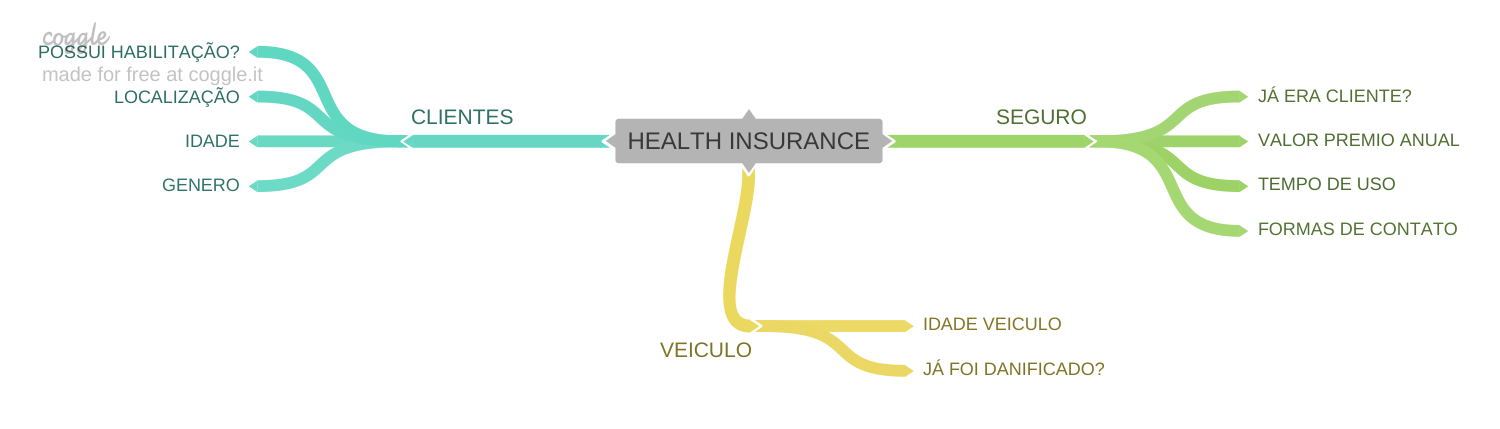

In [15]:
Image('images/HEALTH_INSURANCE.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Clientes

1. Dos dois gêneros, Homens são os que mais procuram seguros para contratar.
2. Pessoas mais velhas se interessam pelo seguro


### 2.2.2. Seguro

1. Das pessoas interessadas no seguro, a maioria tem habilitação
2. Das pessoas interessadas no seguro, a maioria não possuia seguro antes
3. Quanto maior o valor que o cliente paga pelo prêmio anual, mais a chance dele se interessar pelo seguro
4. Quanto mais tempo a pessoa possui seguro de vida, maiores as chances de aceitar um seguro veicular

### 2.2.3. Veículo

1. Quanto mais velho o veículo, mais chance da pessoa se interessar pelo seguro
2. CLientes que já possuiram sinistros no passado possuem mais chances de querer o seguro

## 2.3. Feature Engineering

In [16]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [17]:
df3 = df2.copy()

Como no Data Descriptive não encontramos nada de discrepante nos dados, por hora não há o que filtrar

# 4.0. EDA

In [18]:
df4 = df3.copy()

## 4.1. Univariate Analysis

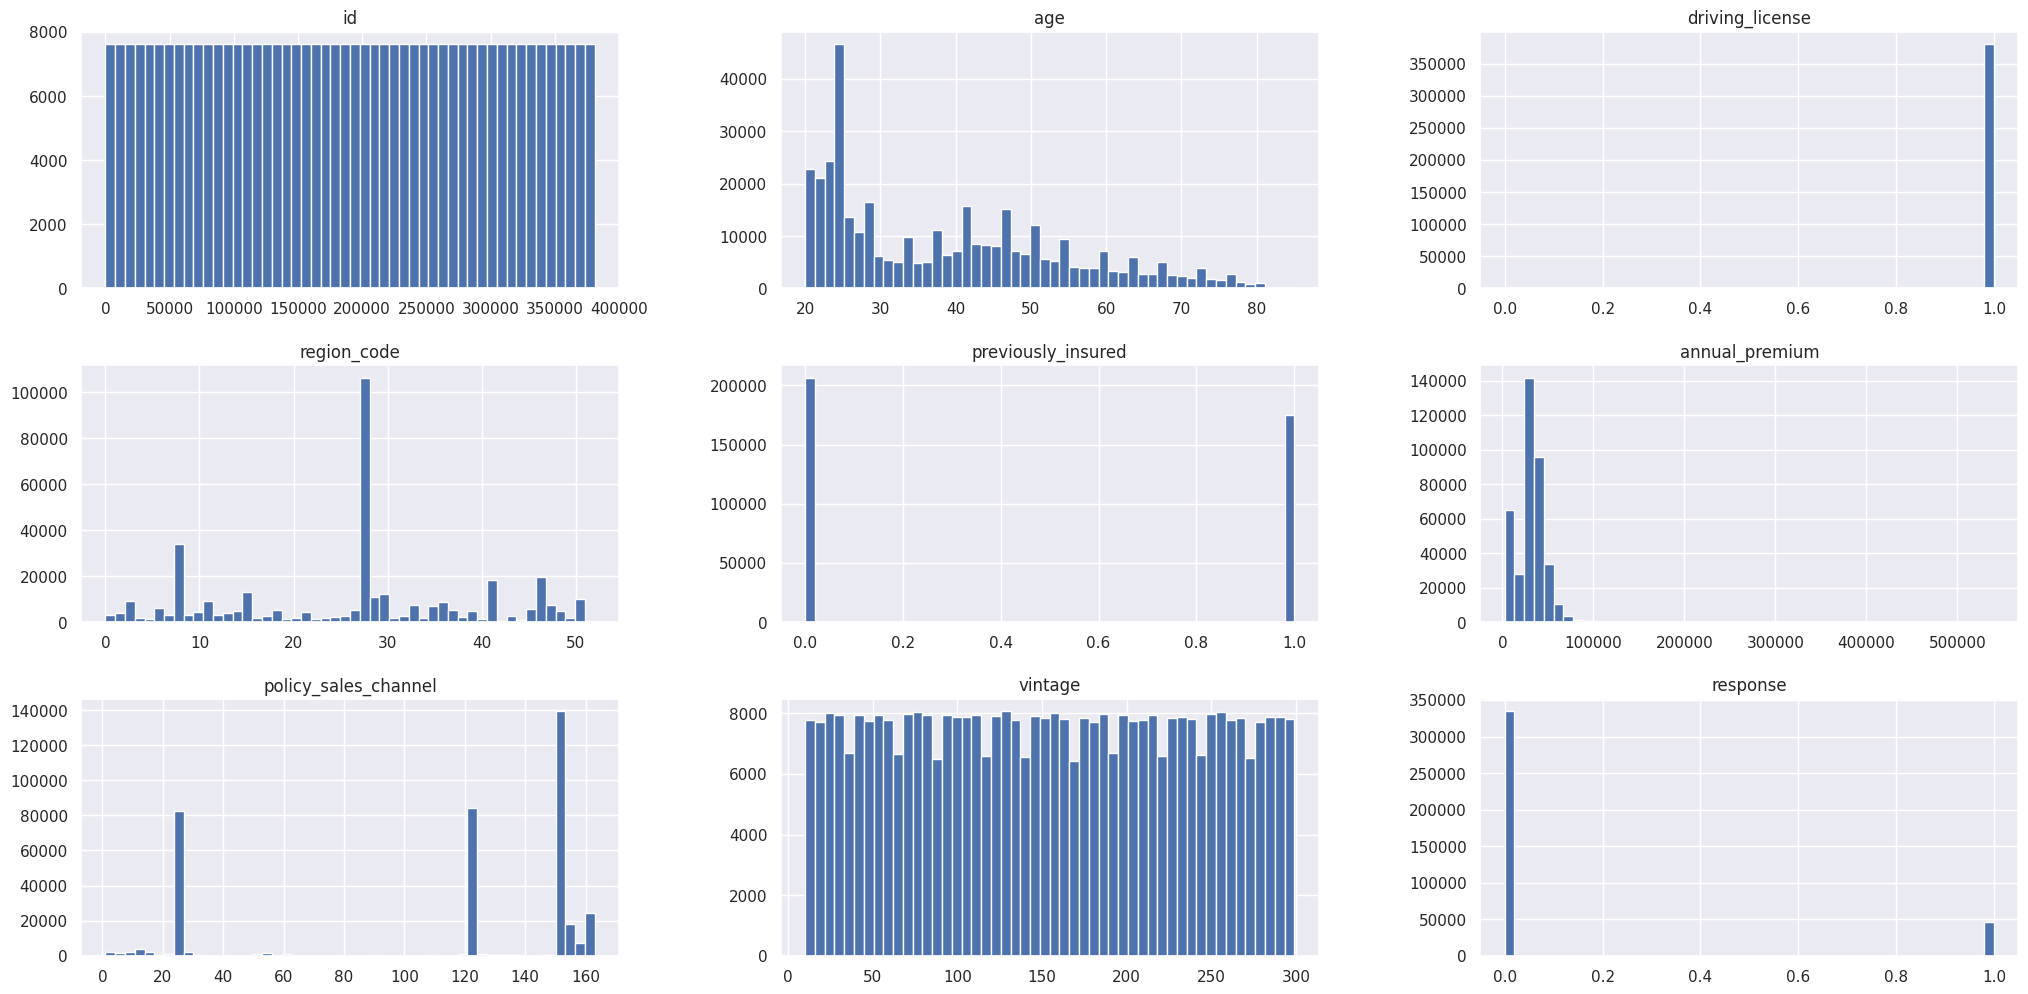

In [19]:
num_attributes.hist(bins = 50);

## 4.2. Bivariate Analysis

In [20]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

O que o modelo quer fazer? <br>
Ele quer descobrir um hiperplano no espaço que pode separar essas classes<br>
Com isso, queremos encontrar algumas features que nos ajude a separar os clientes que querem o novo produto do que não querem <br>
Features que misturam isso são ruins, confundem mais que ajudam o classificador<br>
Olhamos se cada variável vai bagunçar ou ajudar a separar o dataset<br>
Procuramos variáveis que são separadas entre si

### 4.1.1. Age

<Axes: xlabel='response', ylabel='age'>

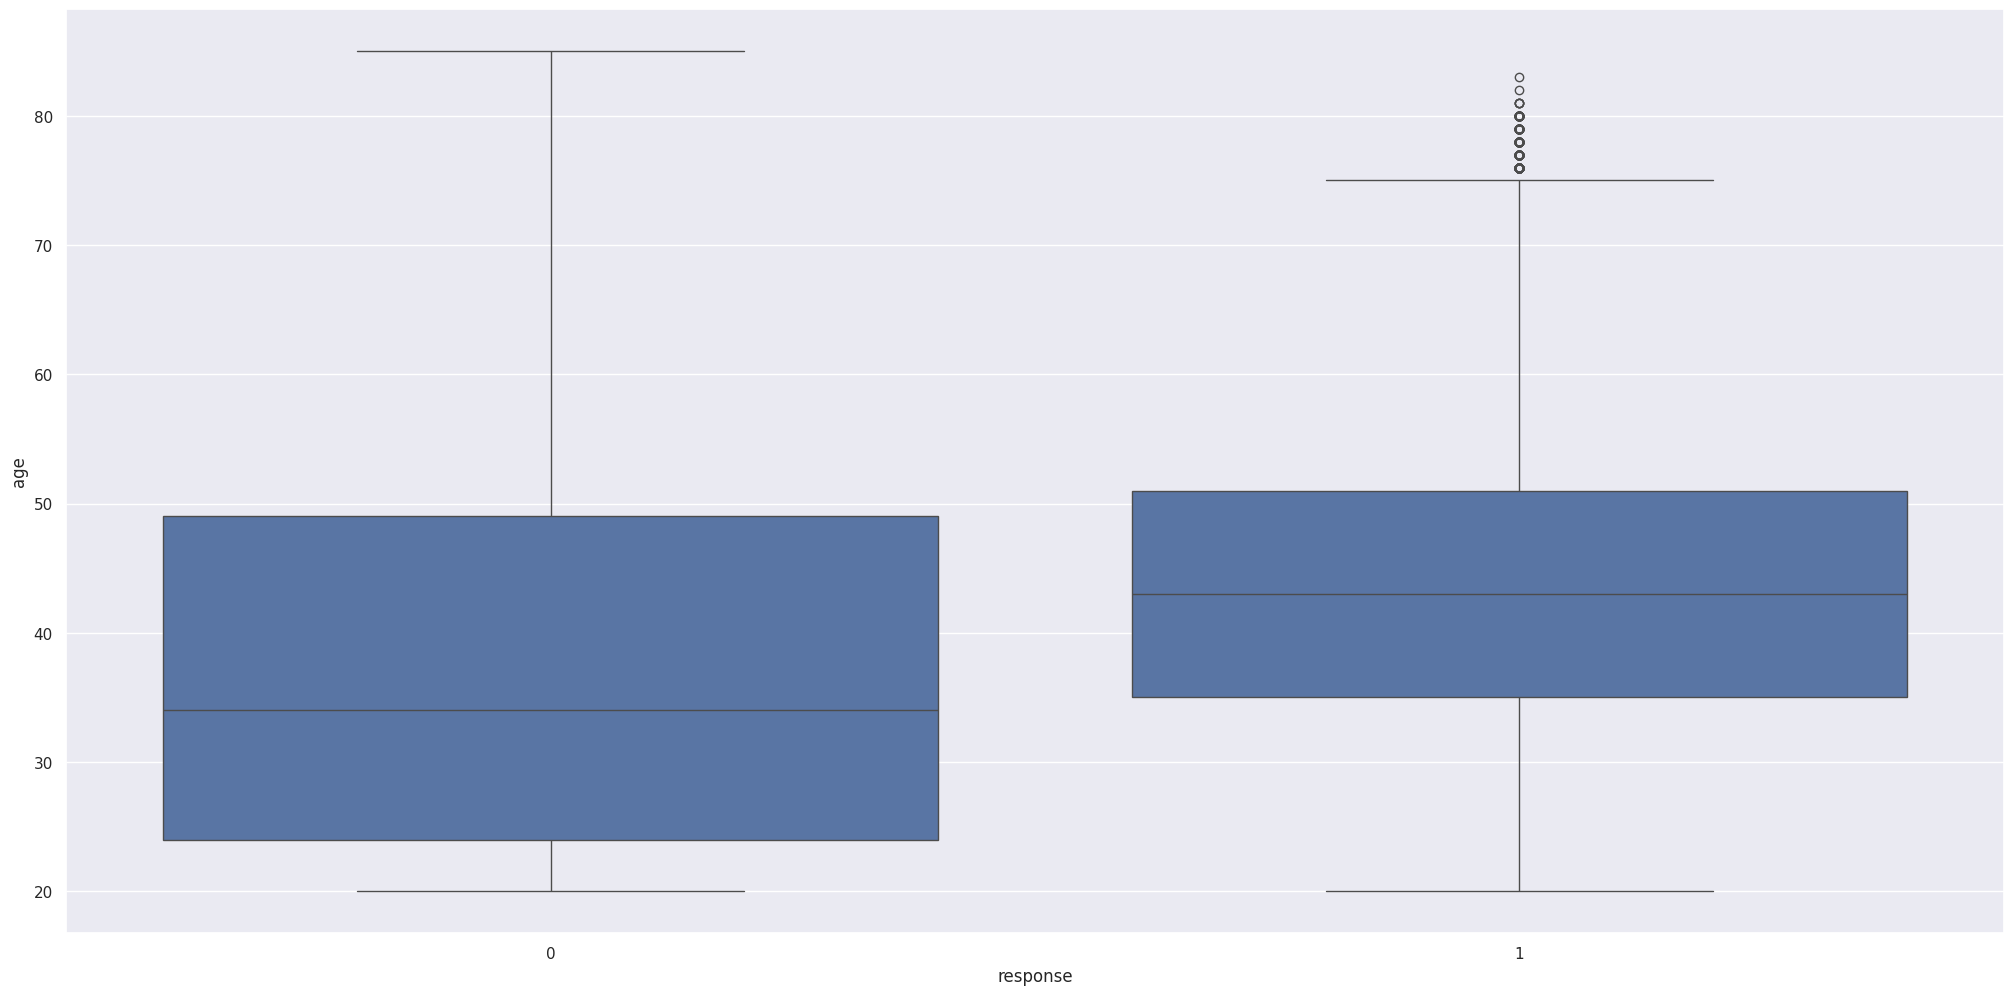

In [21]:
# age - Numeros Naturais
# Quero olhar as medianas de cada um dos grupos com relação a idade
sns.boxplot( x = 'response', y = 'age', data = df4)

#Vemos o distribuição deslocada, uma mediana maior pra quem adiquiriu o seguro, pessoas mais novas não tem interesse

<Axes: xlabel='age', ylabel='Count'>

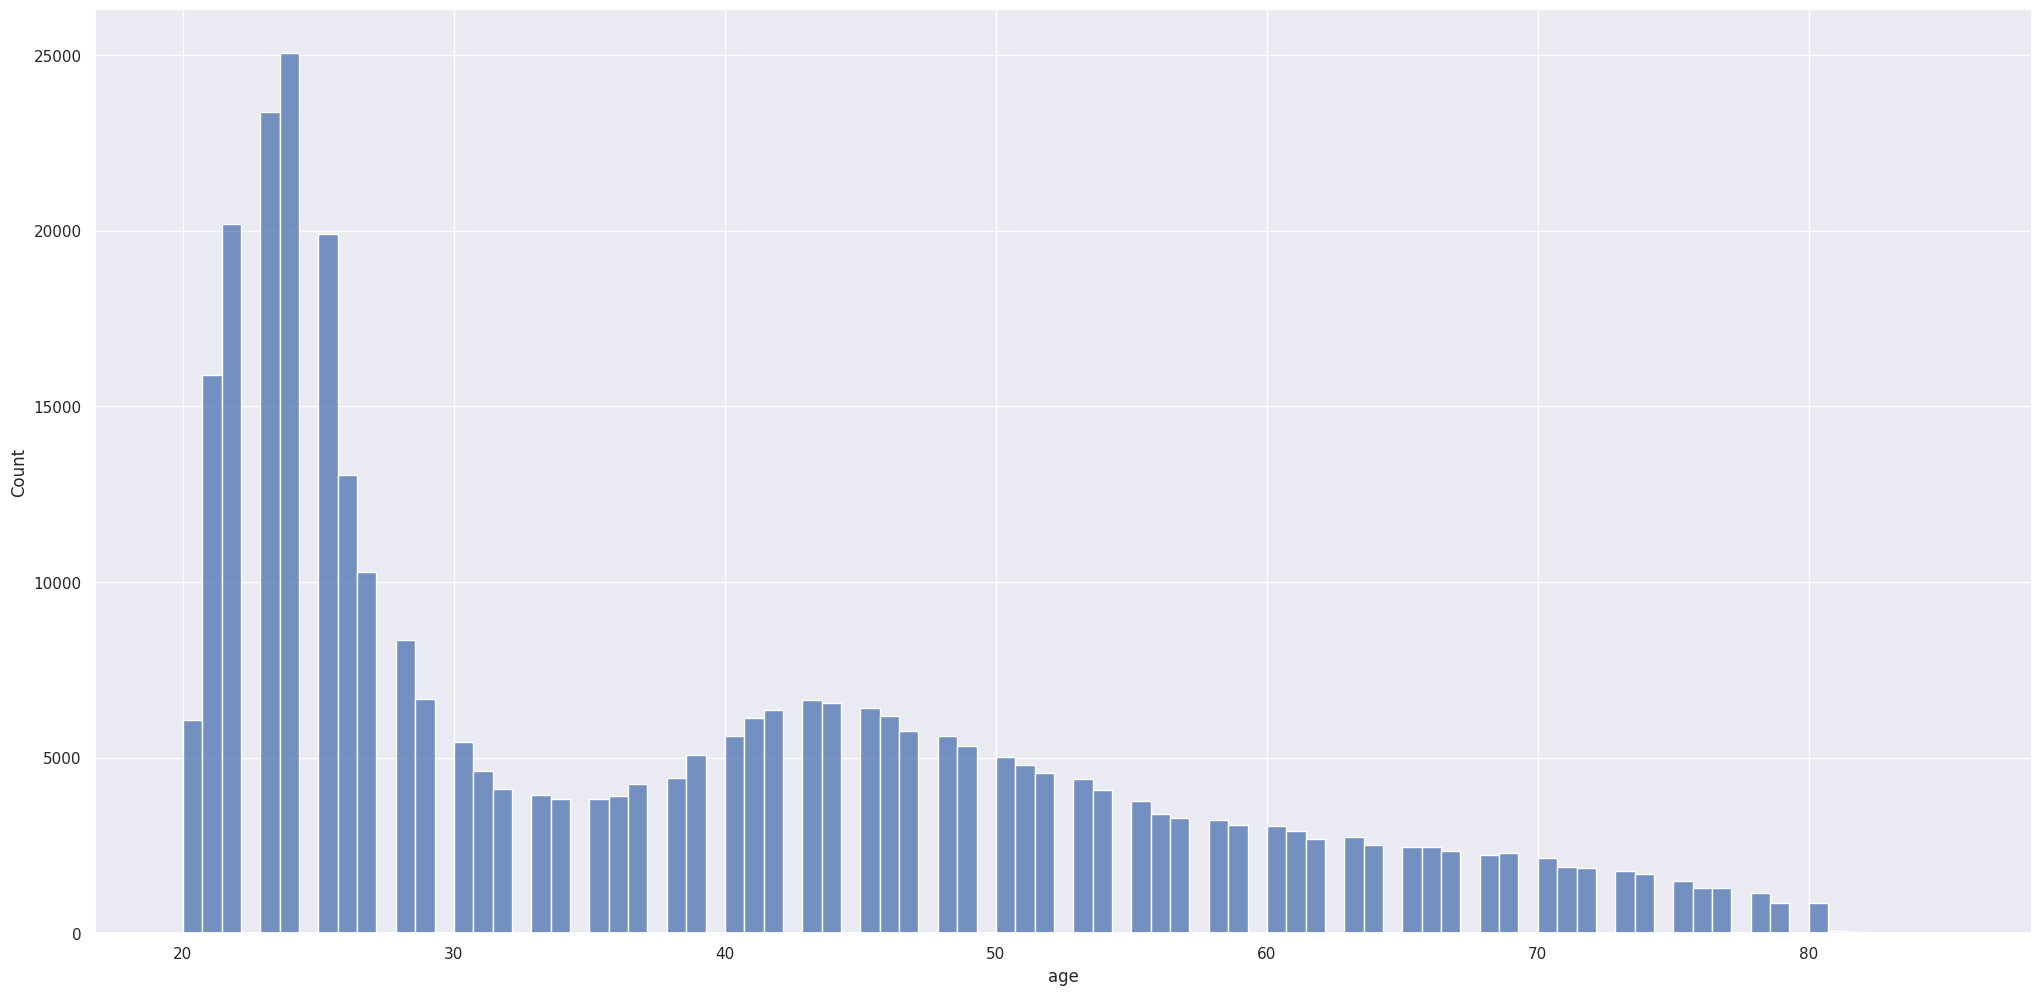

In [22]:
aux00 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux00 )

<Axes: xlabel='age', ylabel='Count'>

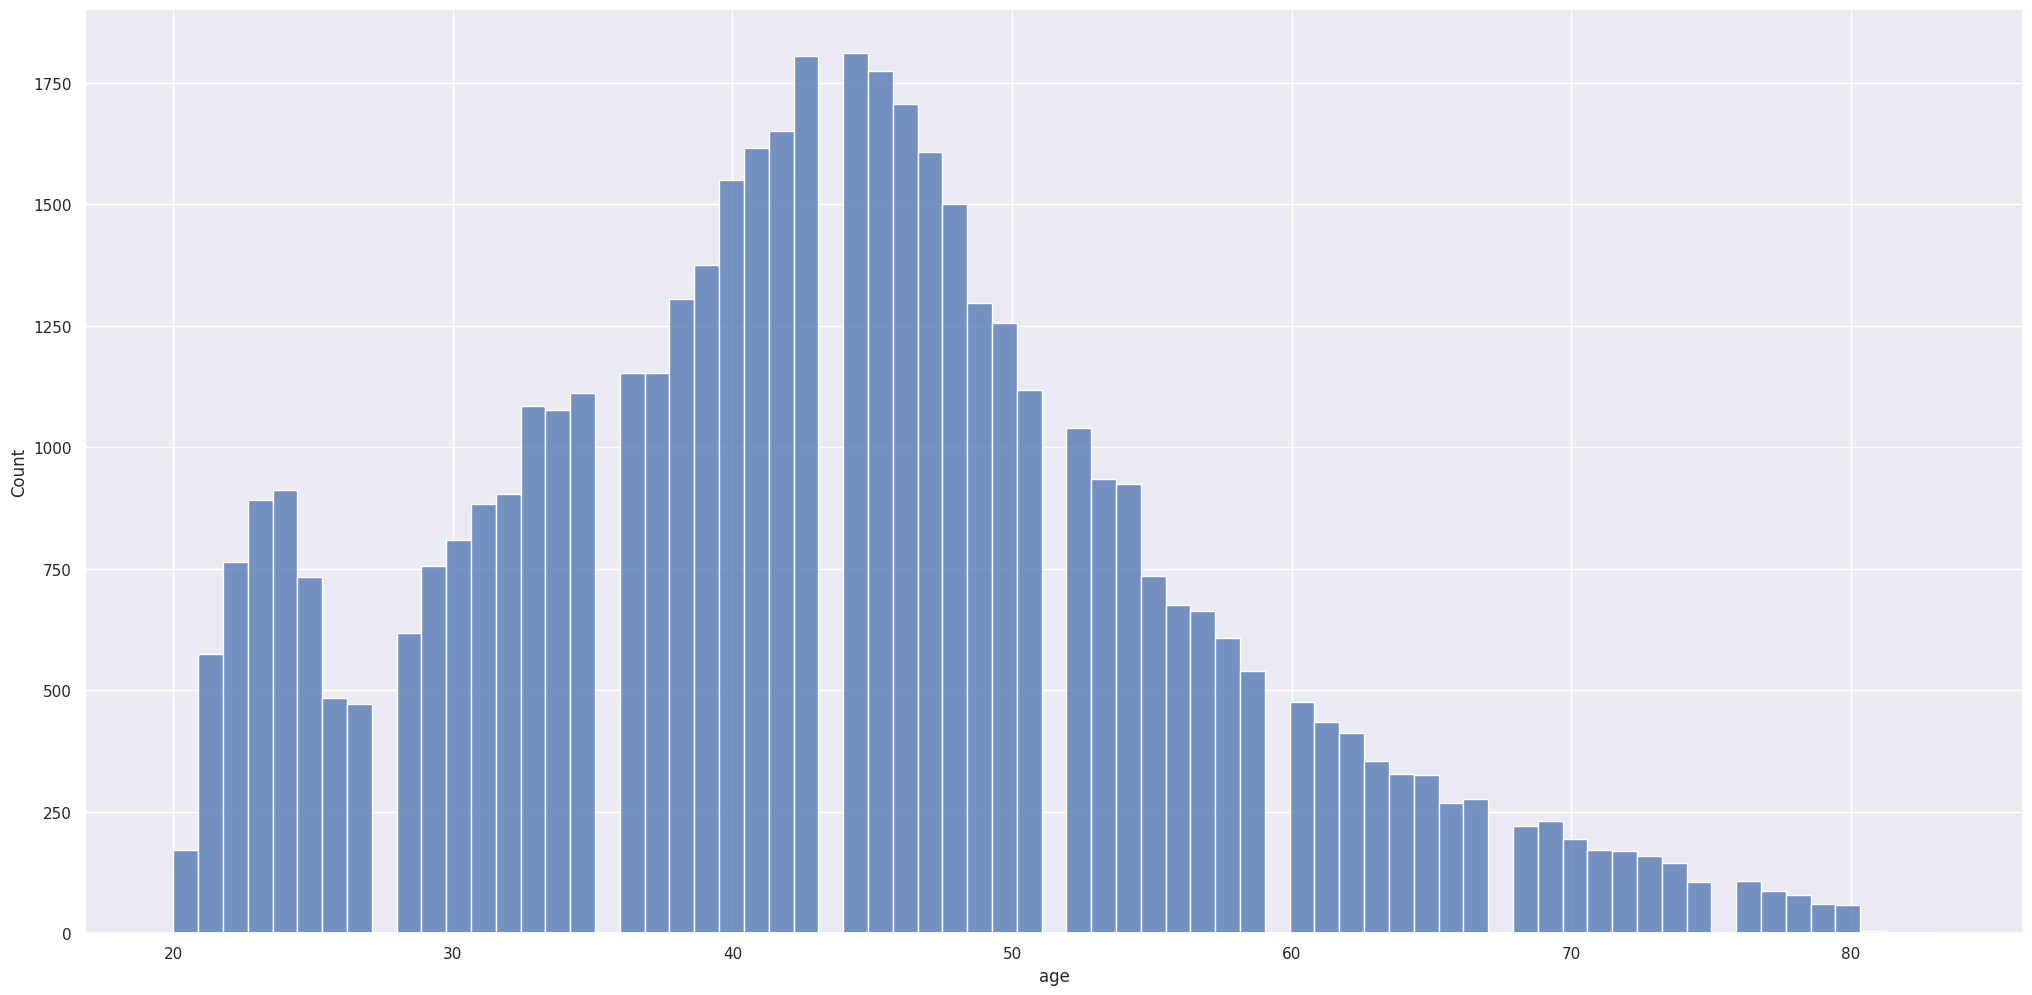

In [23]:
aux01 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux01 )

### 4.1.2. Annual Premium

<Axes: xlabel='response', ylabel='annual_premium'>

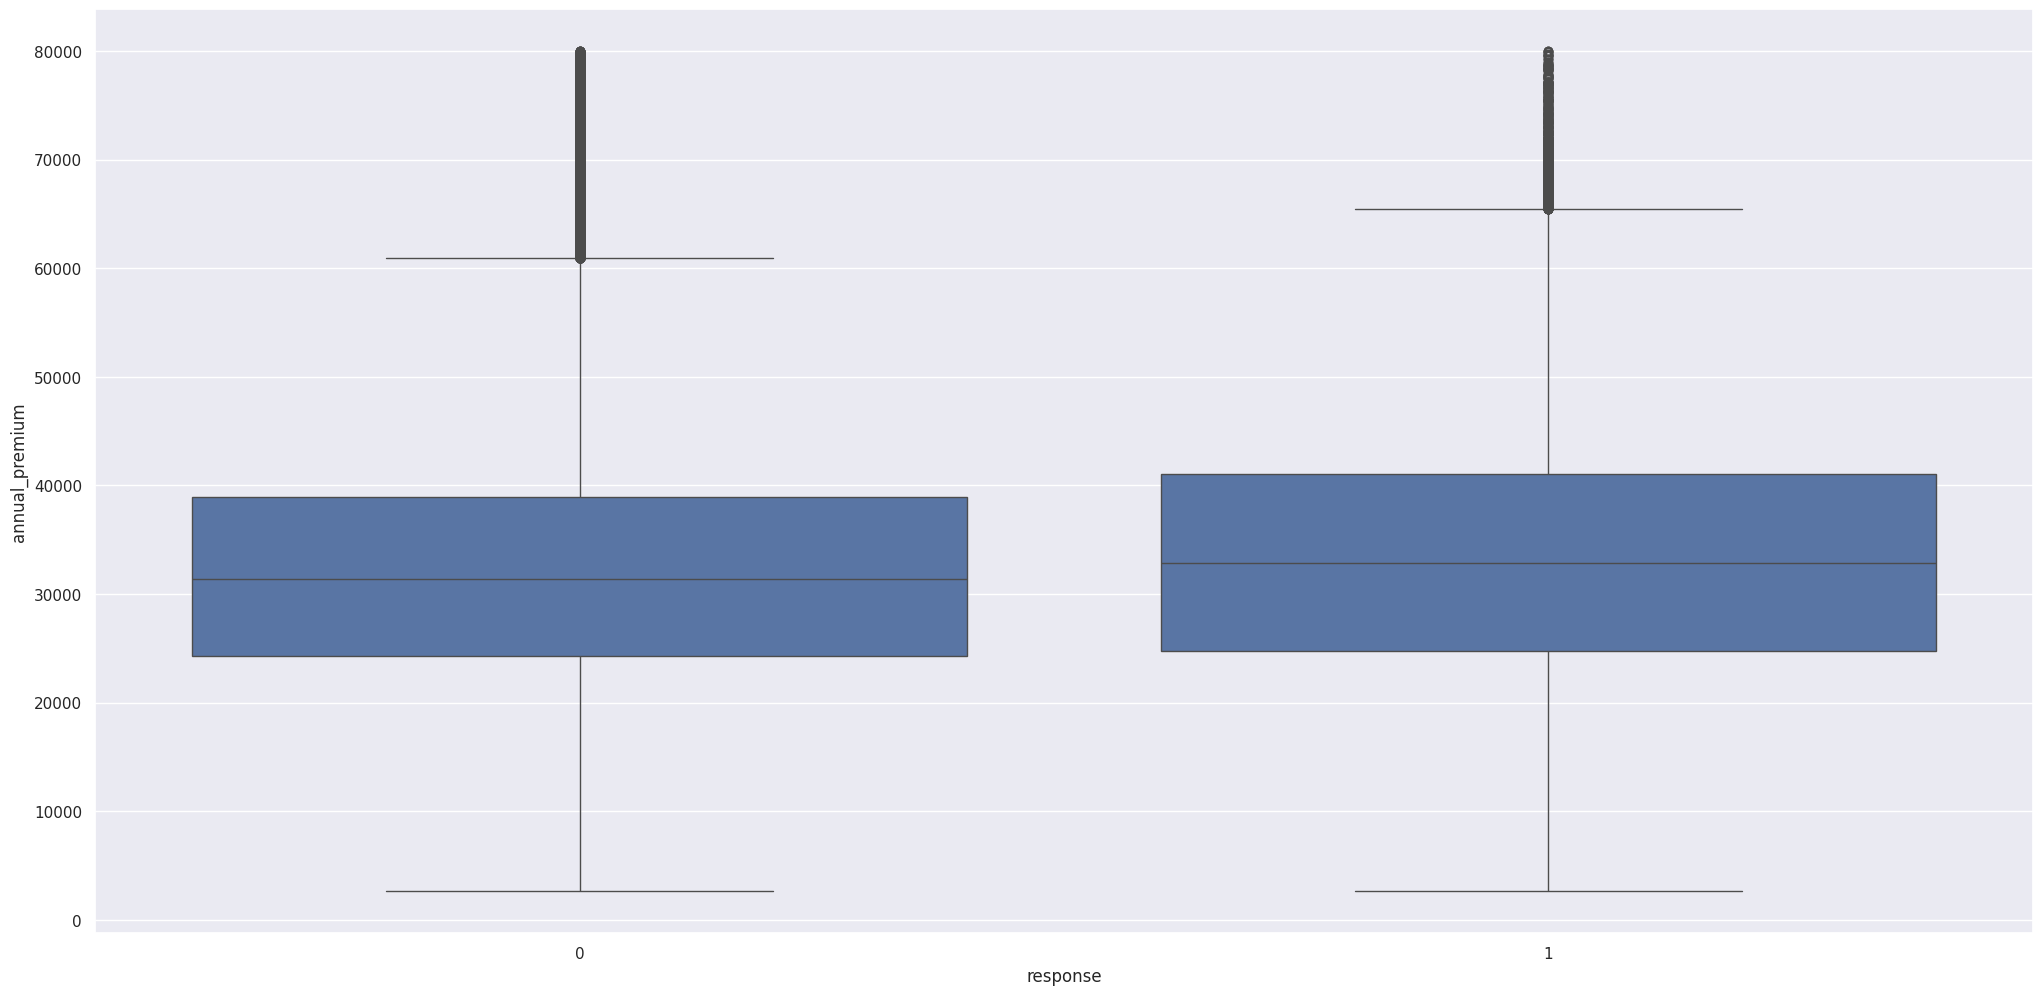

In [24]:
# annual_premium
aux = df4[ df4[ 'annual_premium'] < 80000 ]
sns.boxplot( x = 'response', y = 'annual_premium', data = aux)

# Muitos outliers
# Duas vezes a diferença interquartil
# Medianas muito proximas
#Sozinha não está diferenciando os dados
#Distribuição muito parecida, não me ajuda a diferenciar as observações nas classes
#Não é discriminatória

<Axes: xlabel='annual_premium', ylabel='Count'>

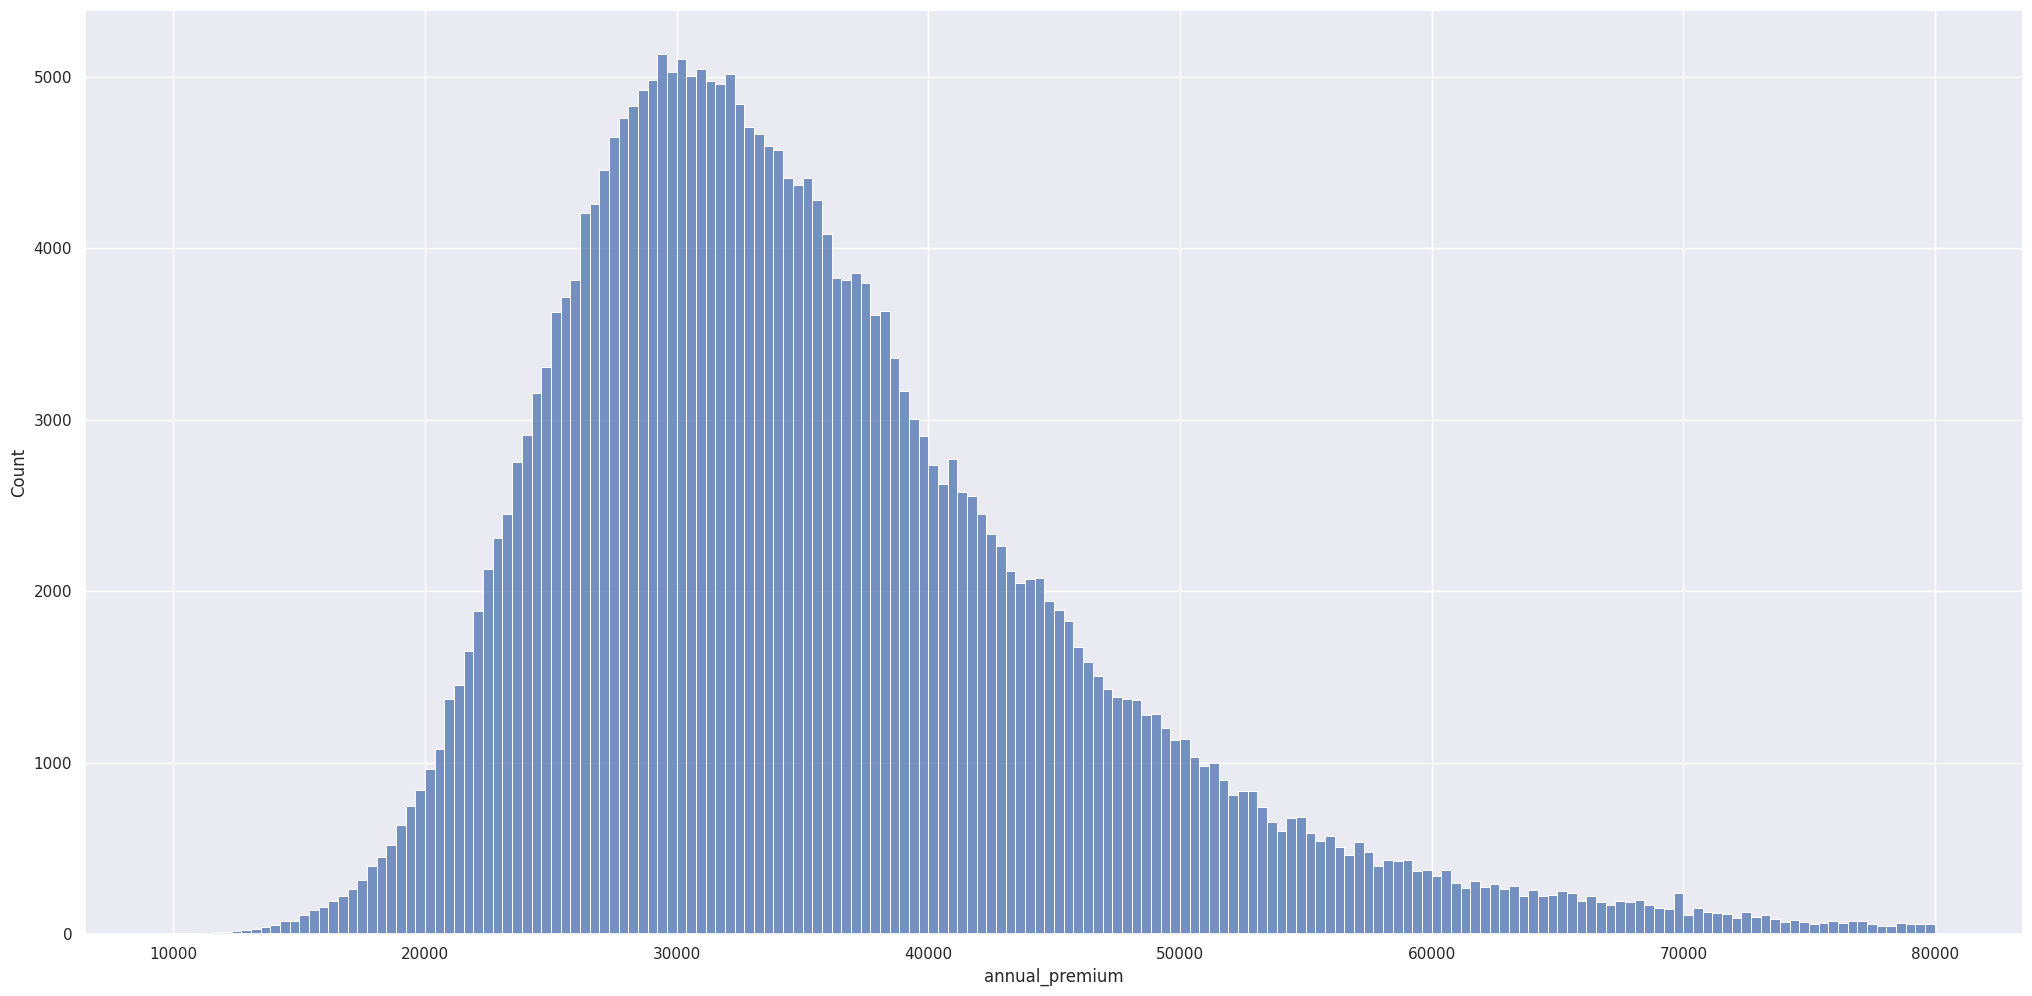

In [25]:
aux = df4[ ( df4[ 'annual_premium'] < 80000 ) & ( df4[ 'annual_premium'] > 10000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='annual_premium', ylabel='Count'>

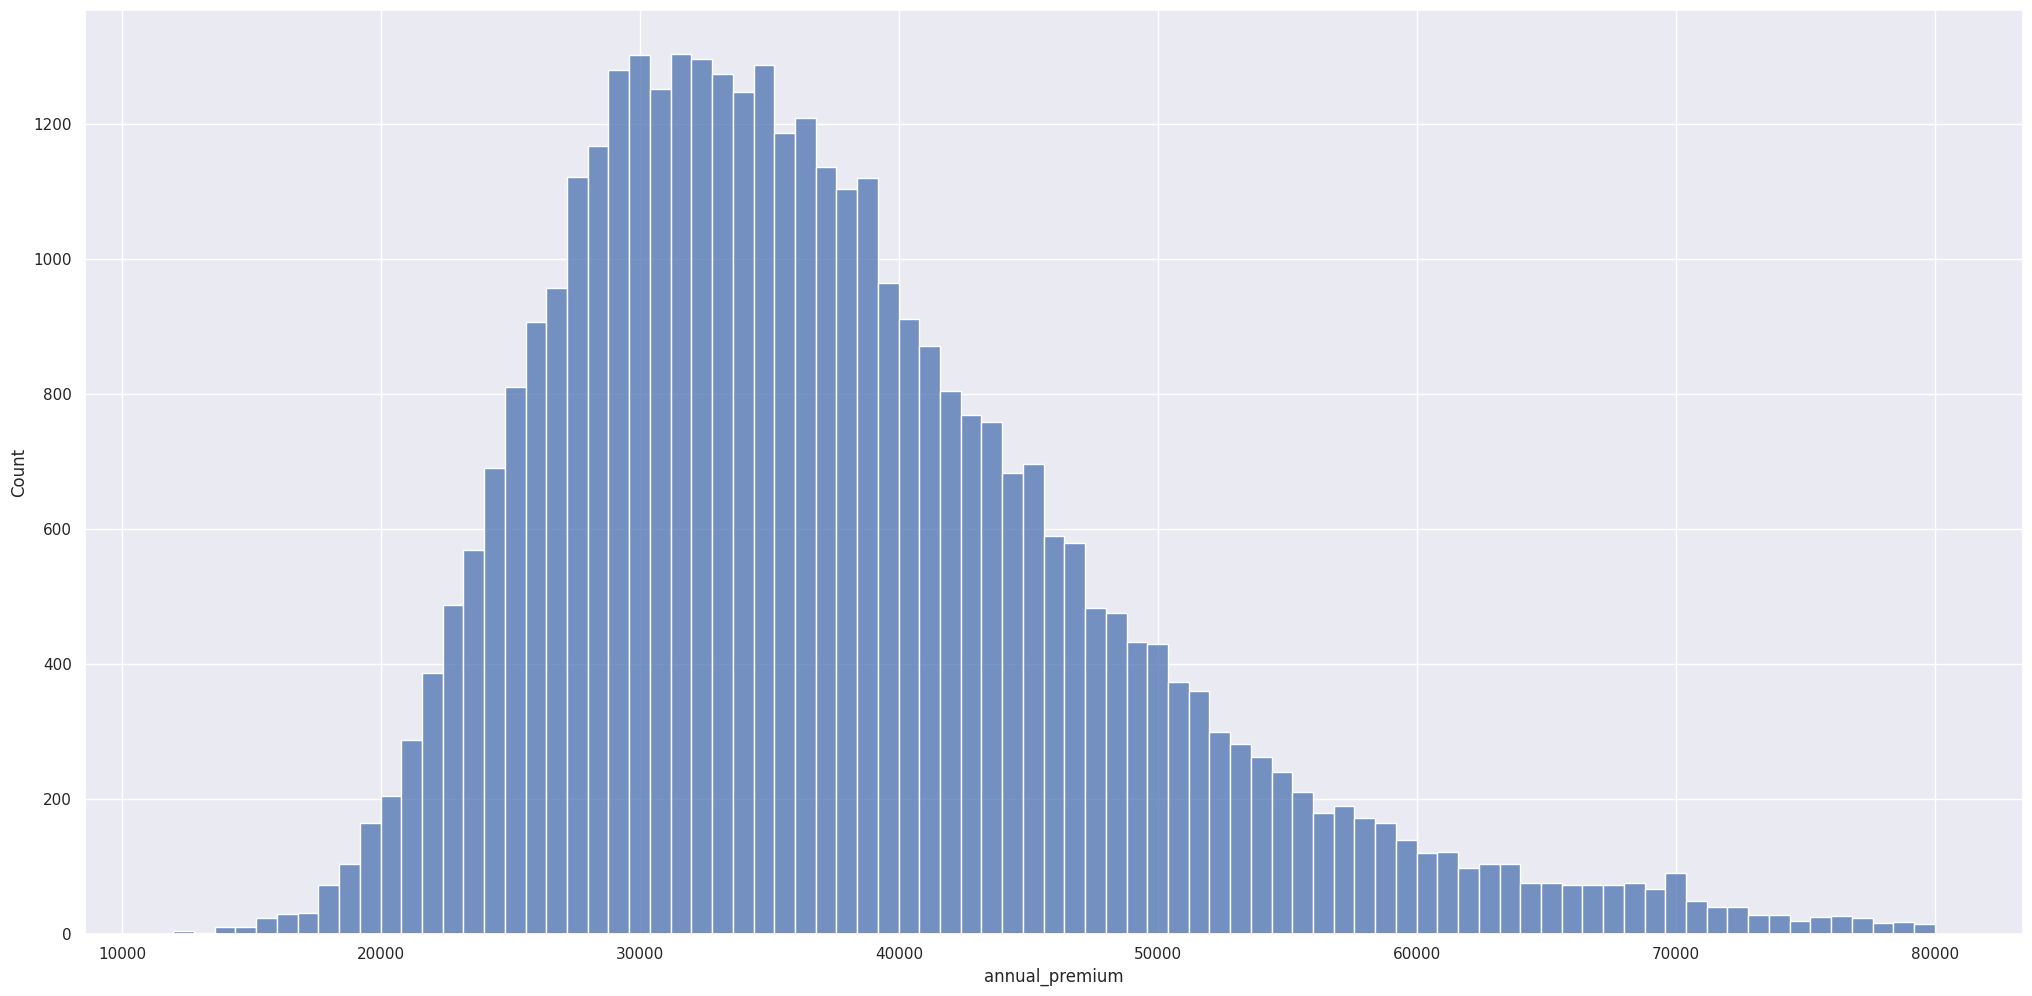

In [26]:
aux = df4[ ( df4[ 'annual_premium'] < 80000 ) & ( df4[ 'annual_premium'] > 10000 )]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

### 4.1.3. Driving License

<Axes: xlabel='response', ylabel='driving_license'>

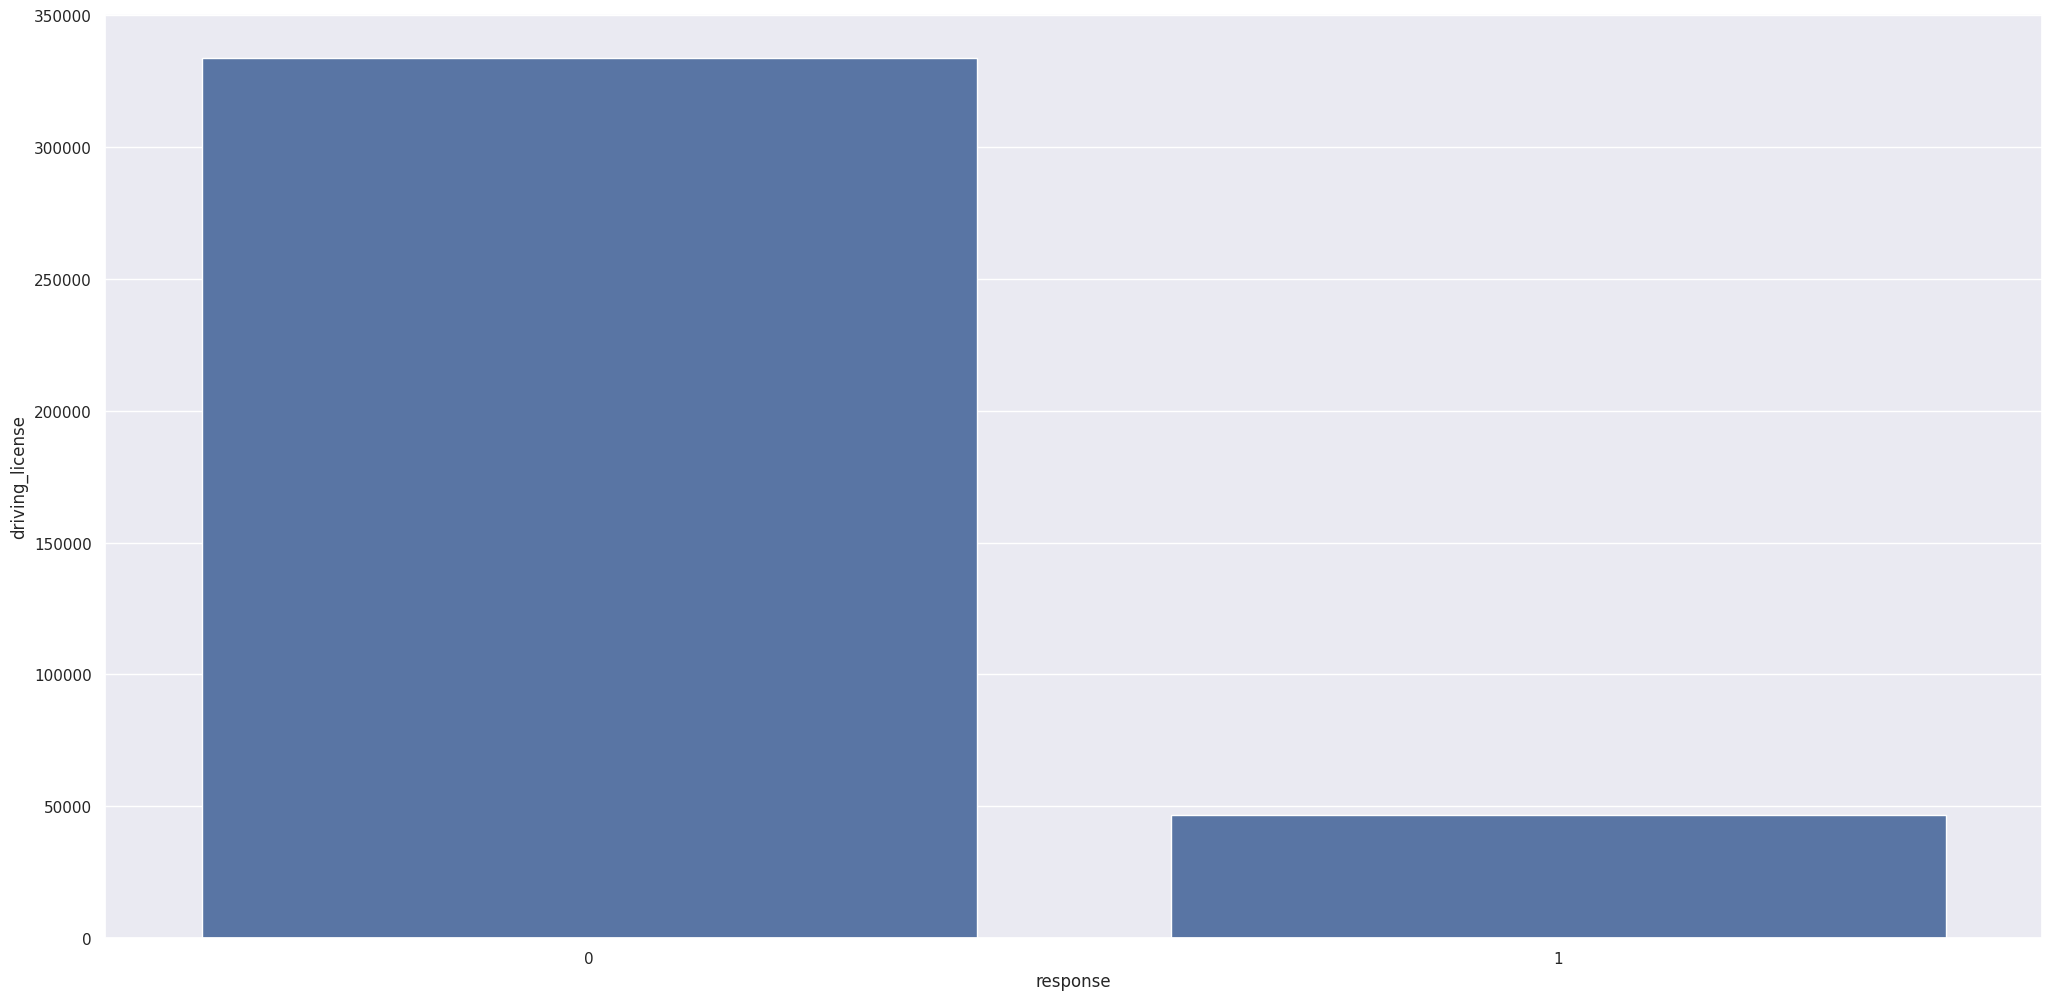

In [27]:
# driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x = 'response', y = 'driving_license', data = aux)

# 333628 pessoas que dirigem e não querem fazer o seguro de carro
# Isso é contraintuitivo pois a maioria das pessoas que dirigem não querem o seguro

### 4.1.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

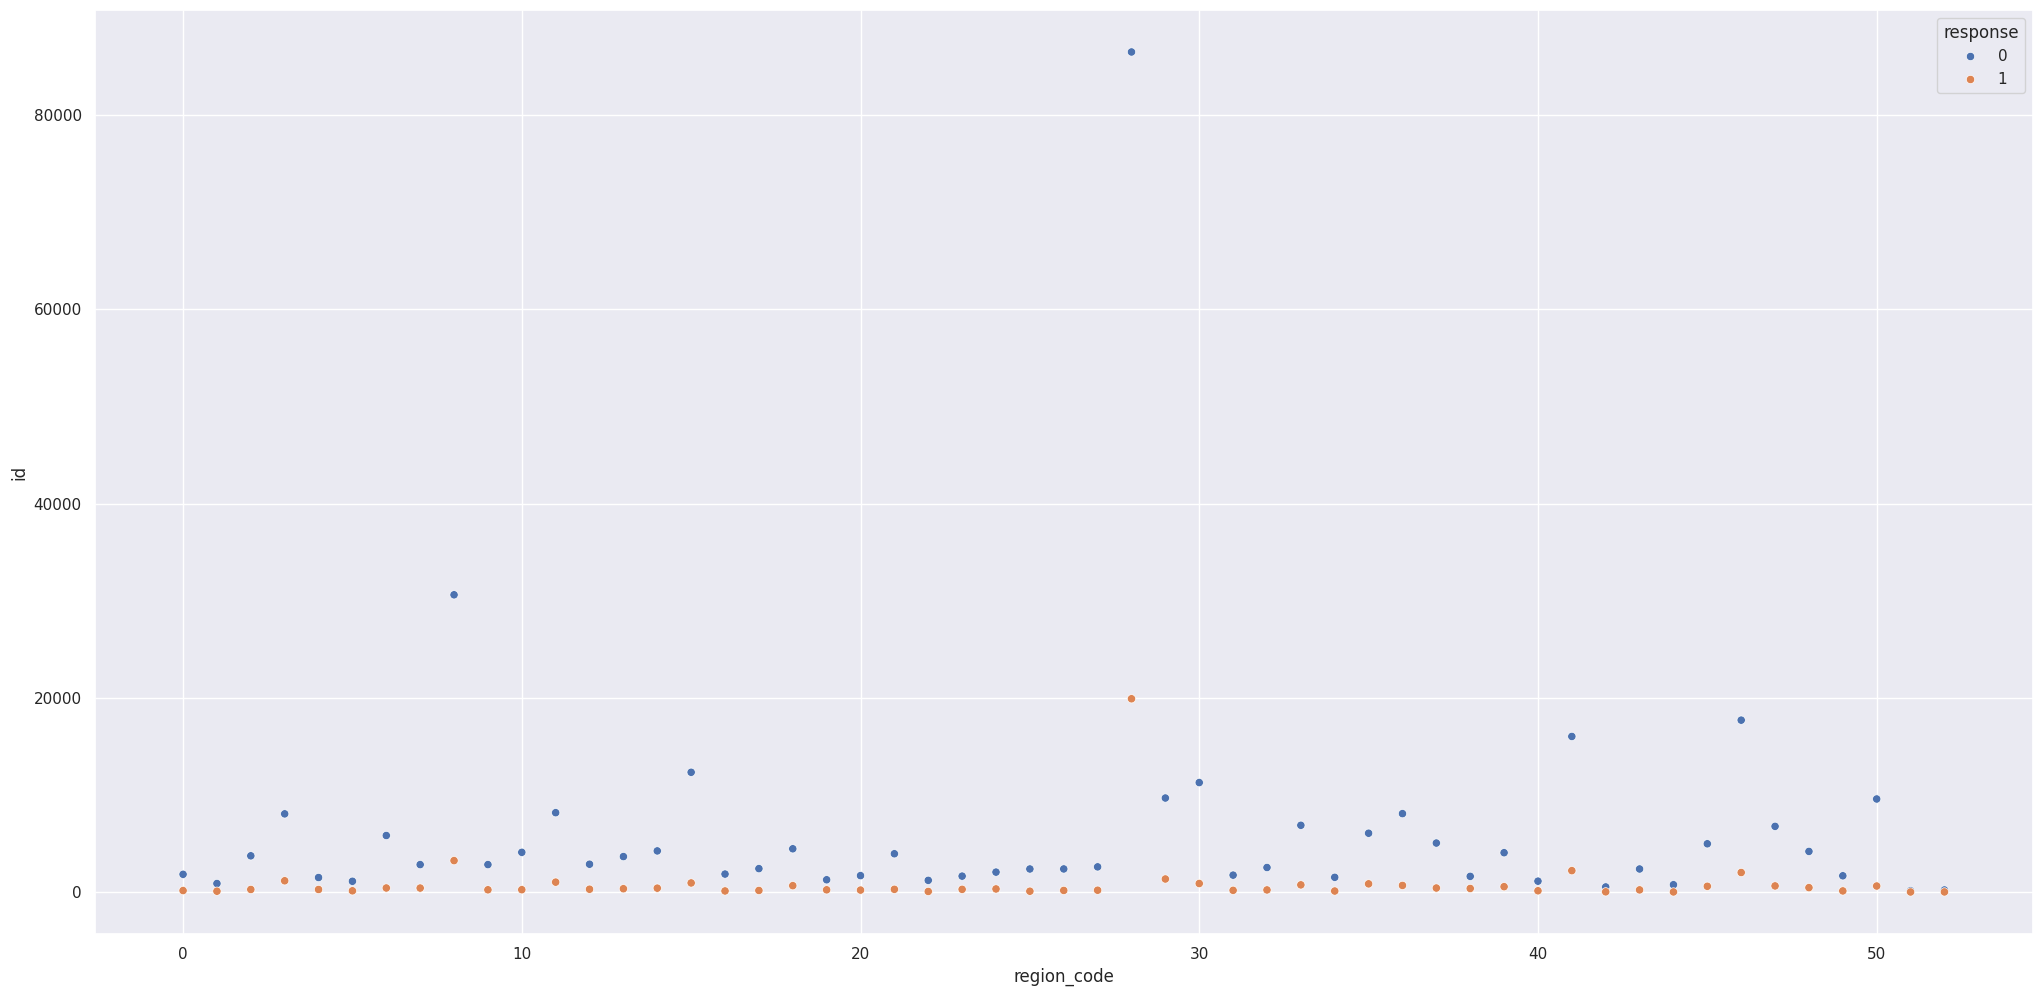

In [28]:
# region_code
aux0 = df4[[ 'id', 'region_code', 'response']].groupby( ['region_code', 'response']).count().reset_index()

sns.scatterplot( x = 'region_code', y = 'id', hue = 'response', data = aux0)

# No region_code 29 aproximadamente, temos uma grande quantidade de 0 em relação a 1
# Porém no restante nada que resolva o problema pois está muito misturado
# Esta variável sozinha não ajuda

### 4.1.5. Previously Insured

In [29]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x/ x.sum(), axis = 1)
#Tabela de contingência
#Mostra a relação de contagem entre as variáveis categóricas
#Pode ser uma variável indicativa
#Pessoas que já tem seguro de carro, não querem mudar
#Pode ser um vazamento de dados ( dizendo pro modelo a resposta já), muito relacionado com a variável resposta, se a pessoa ja tem seguro não vai querer contratar o meu

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.6. Vehicle Age

In [30]:
# vehicle_age
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')
# Acima de 2 anos não discrimina bem
#

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 4.1.7. Policy Sales Channel

<Axes: xlabel='response', ylabel='policy_sales_channel'>

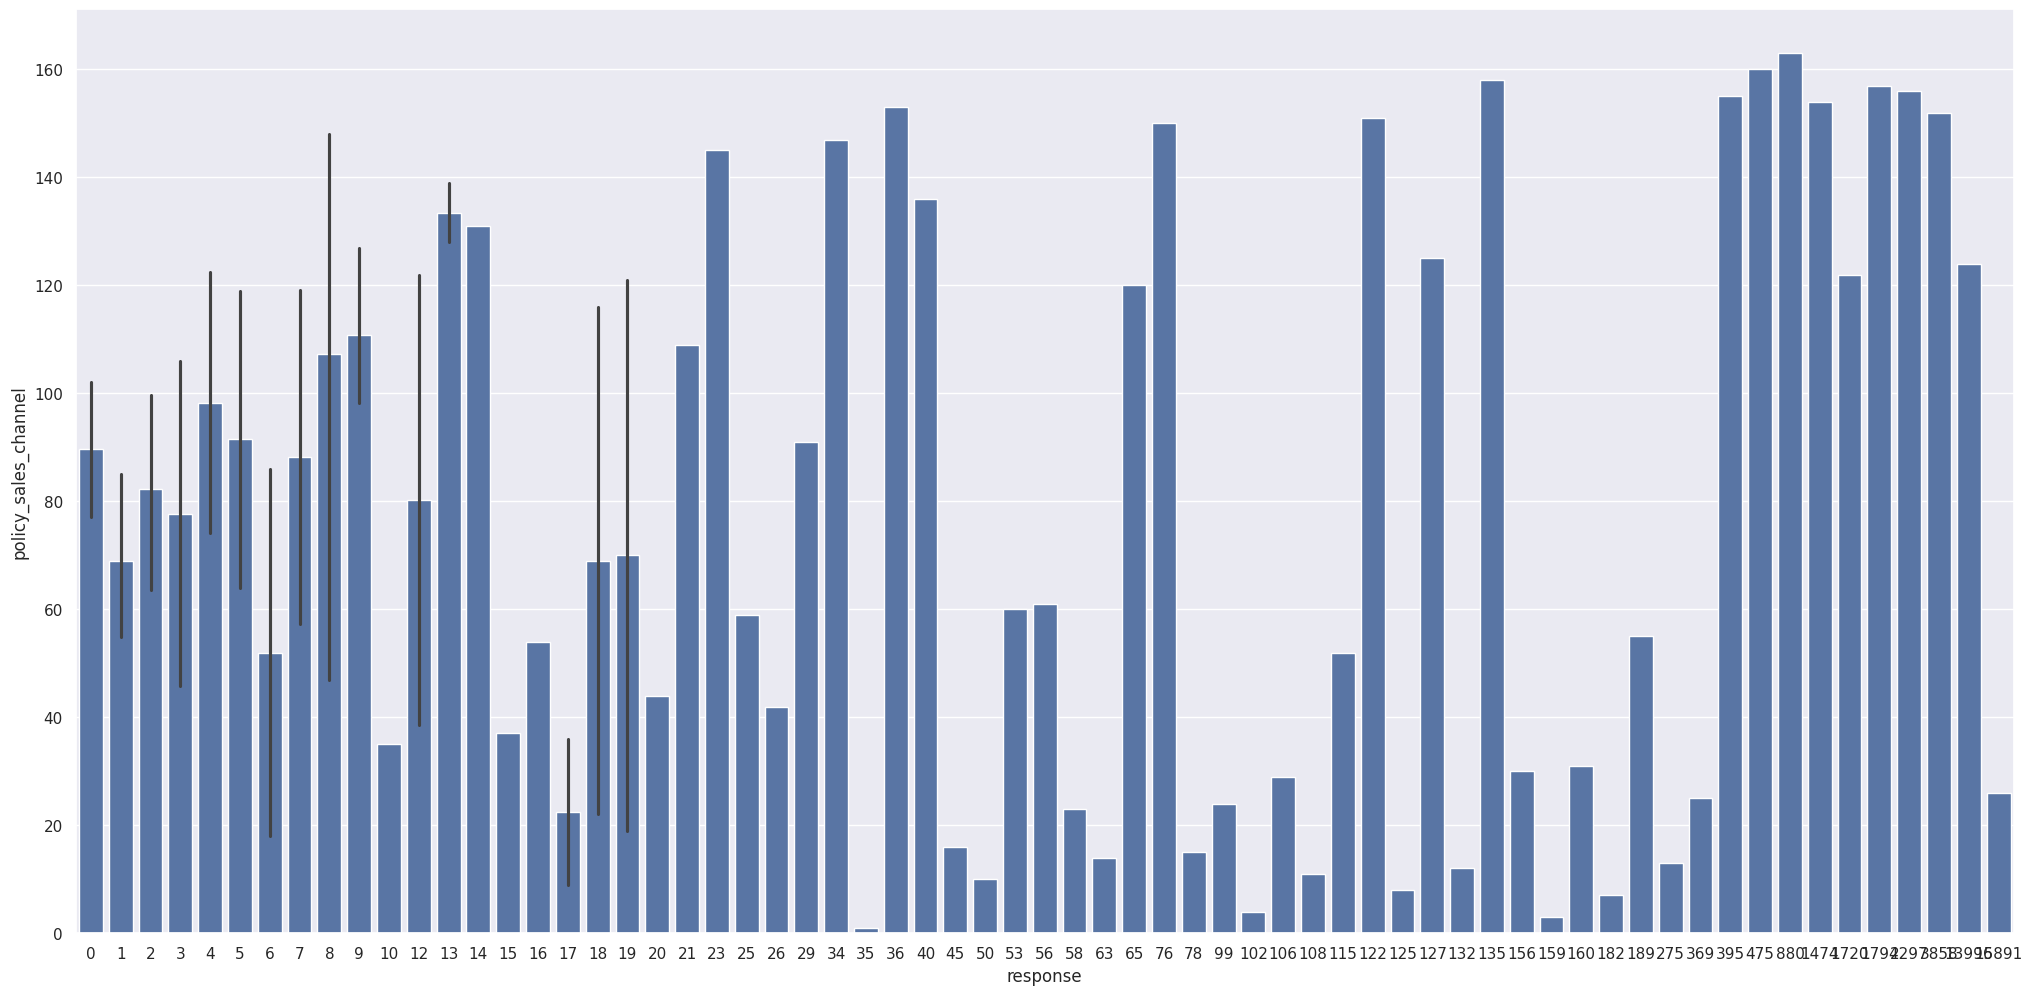

In [31]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x = 'response', y = 'policy_sales_channel', data = aux)

### 4.1.8. Vintage

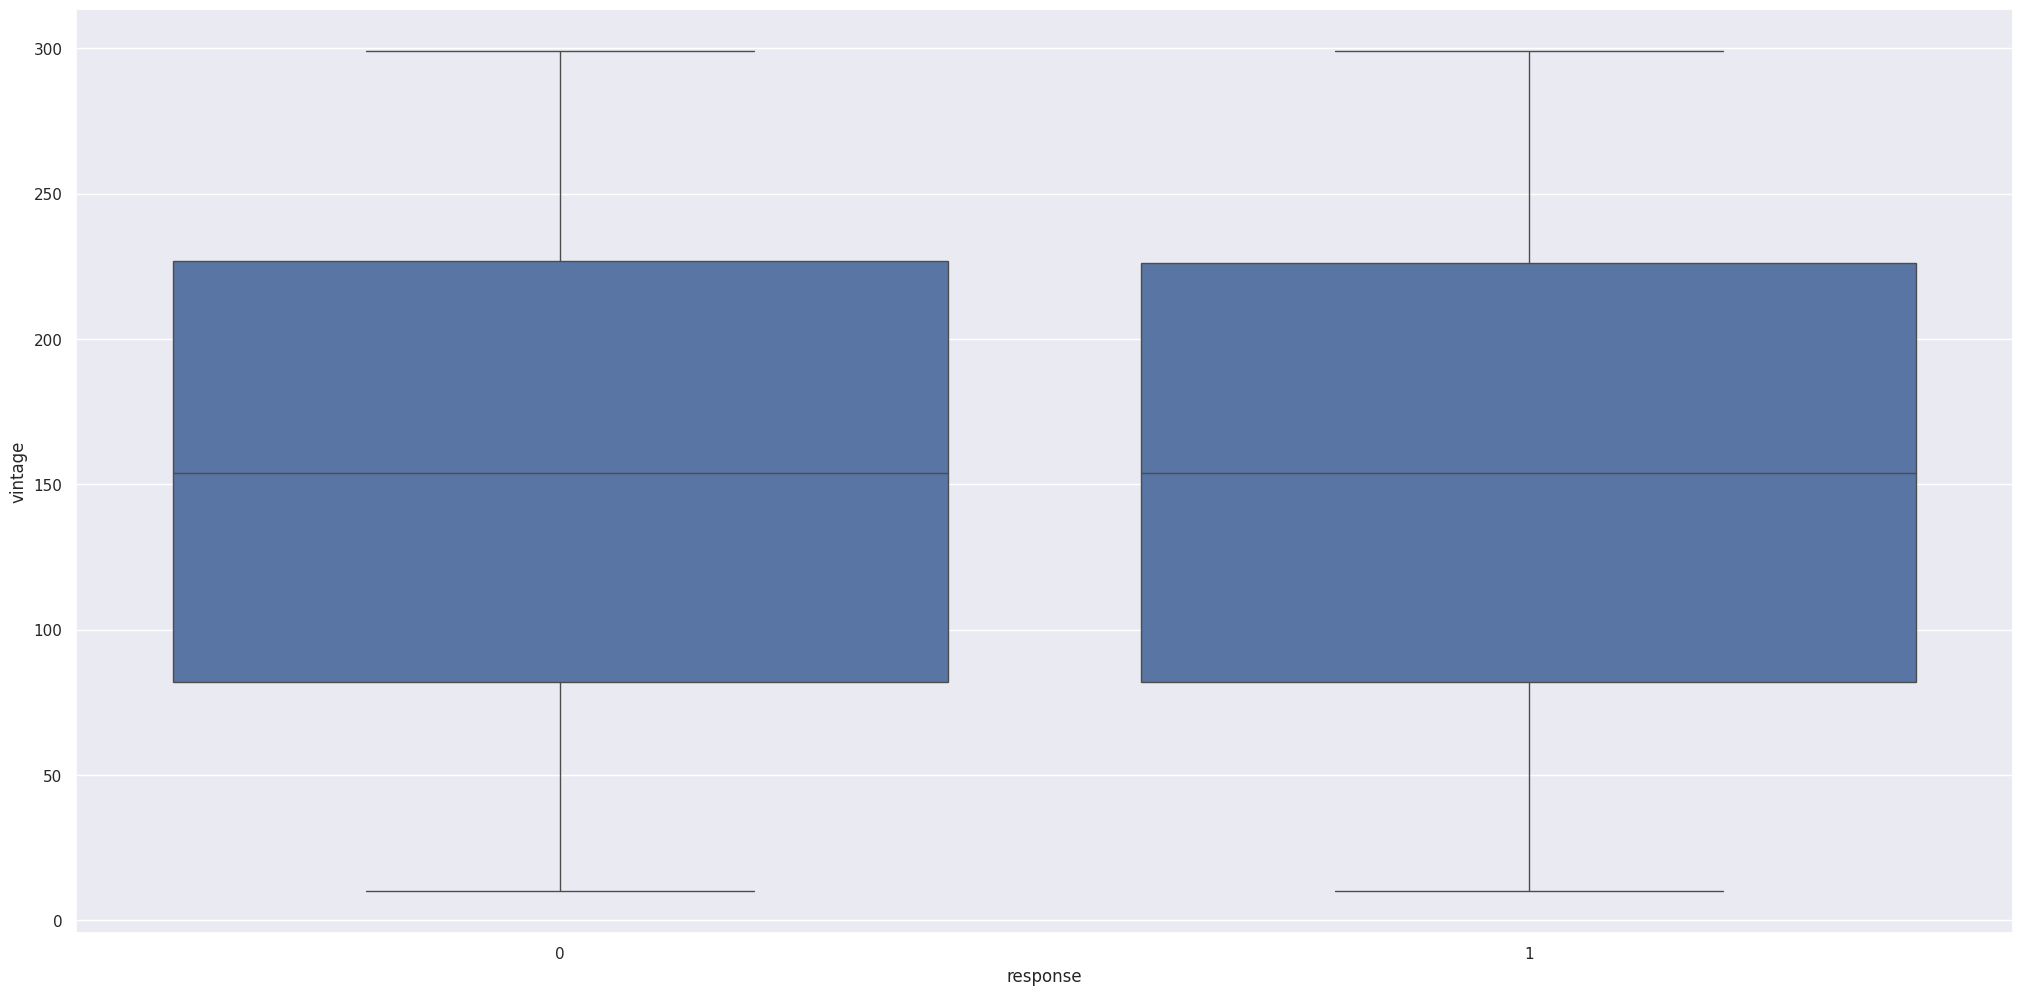

In [32]:
# vintage - tempo que o cliente está na base
sns.boxplot(x='response',y='vintage',data=df4);

# São parecidos mas não diz muita coisa

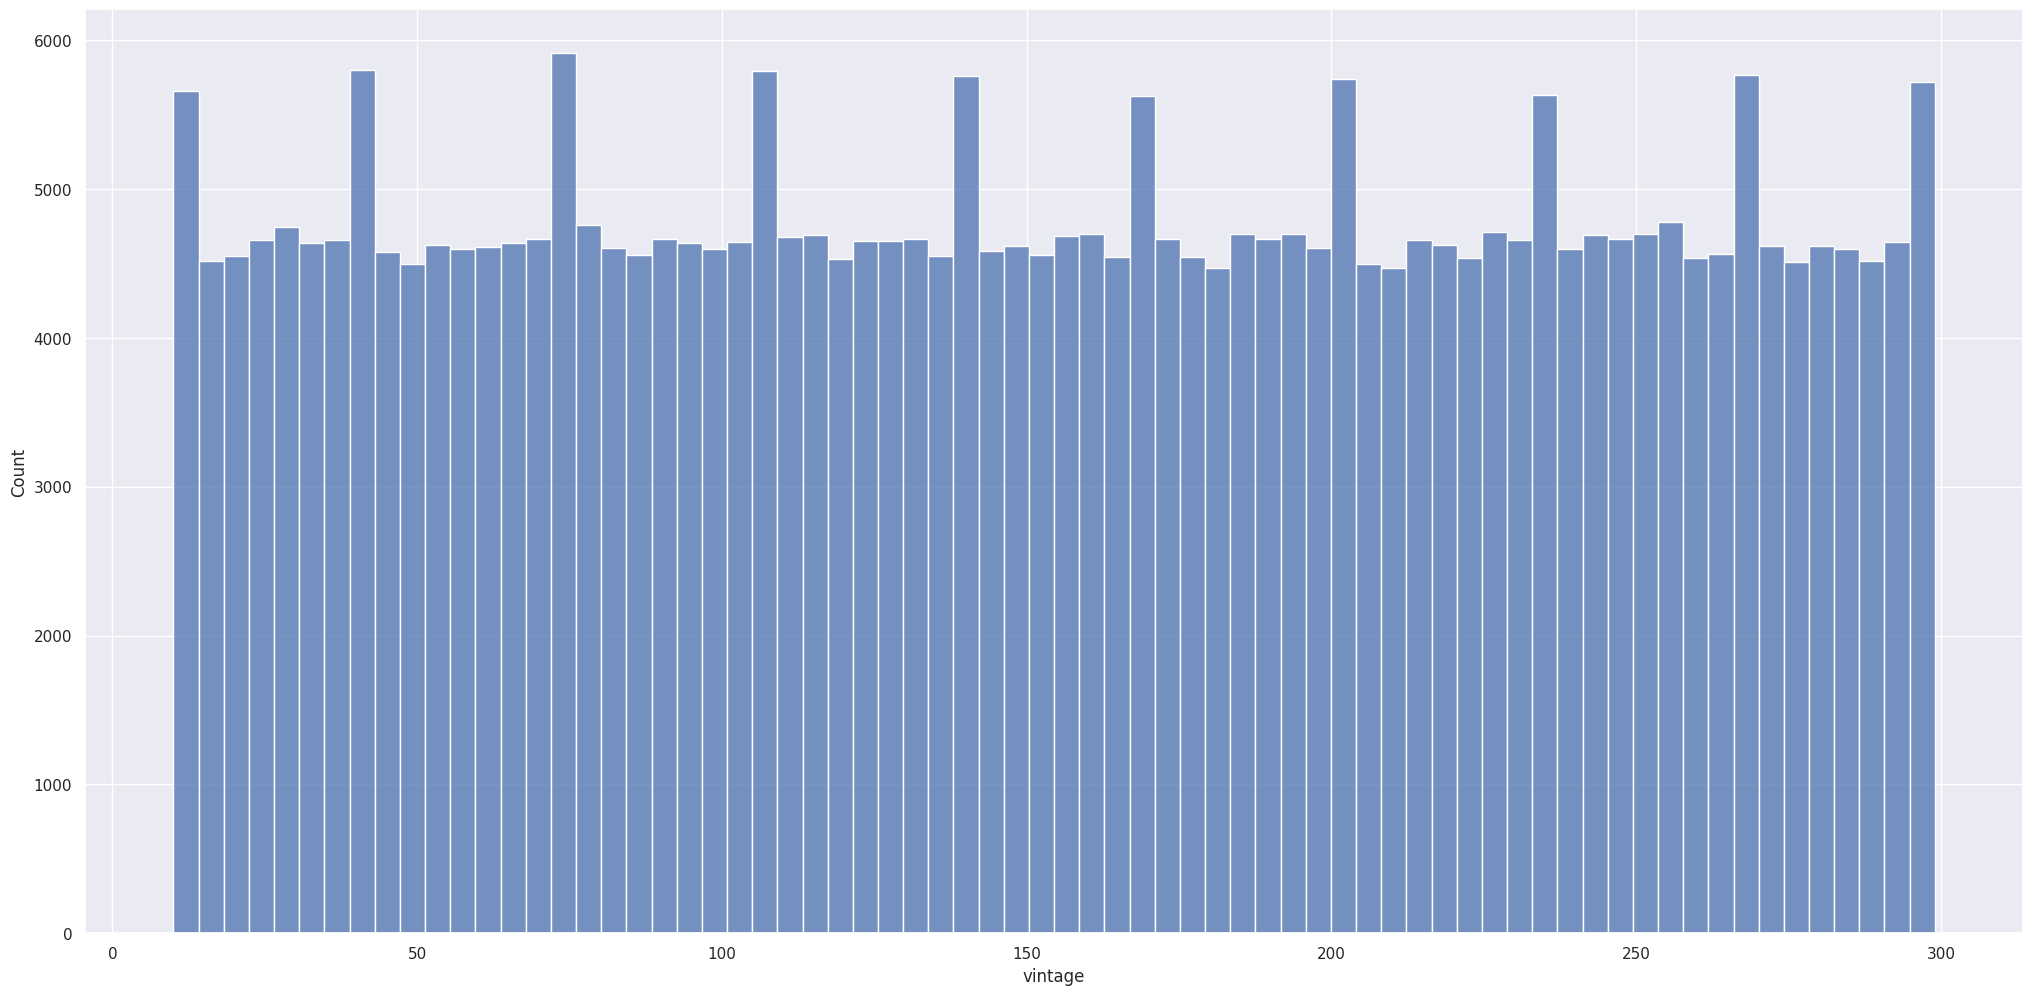

In [33]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00);

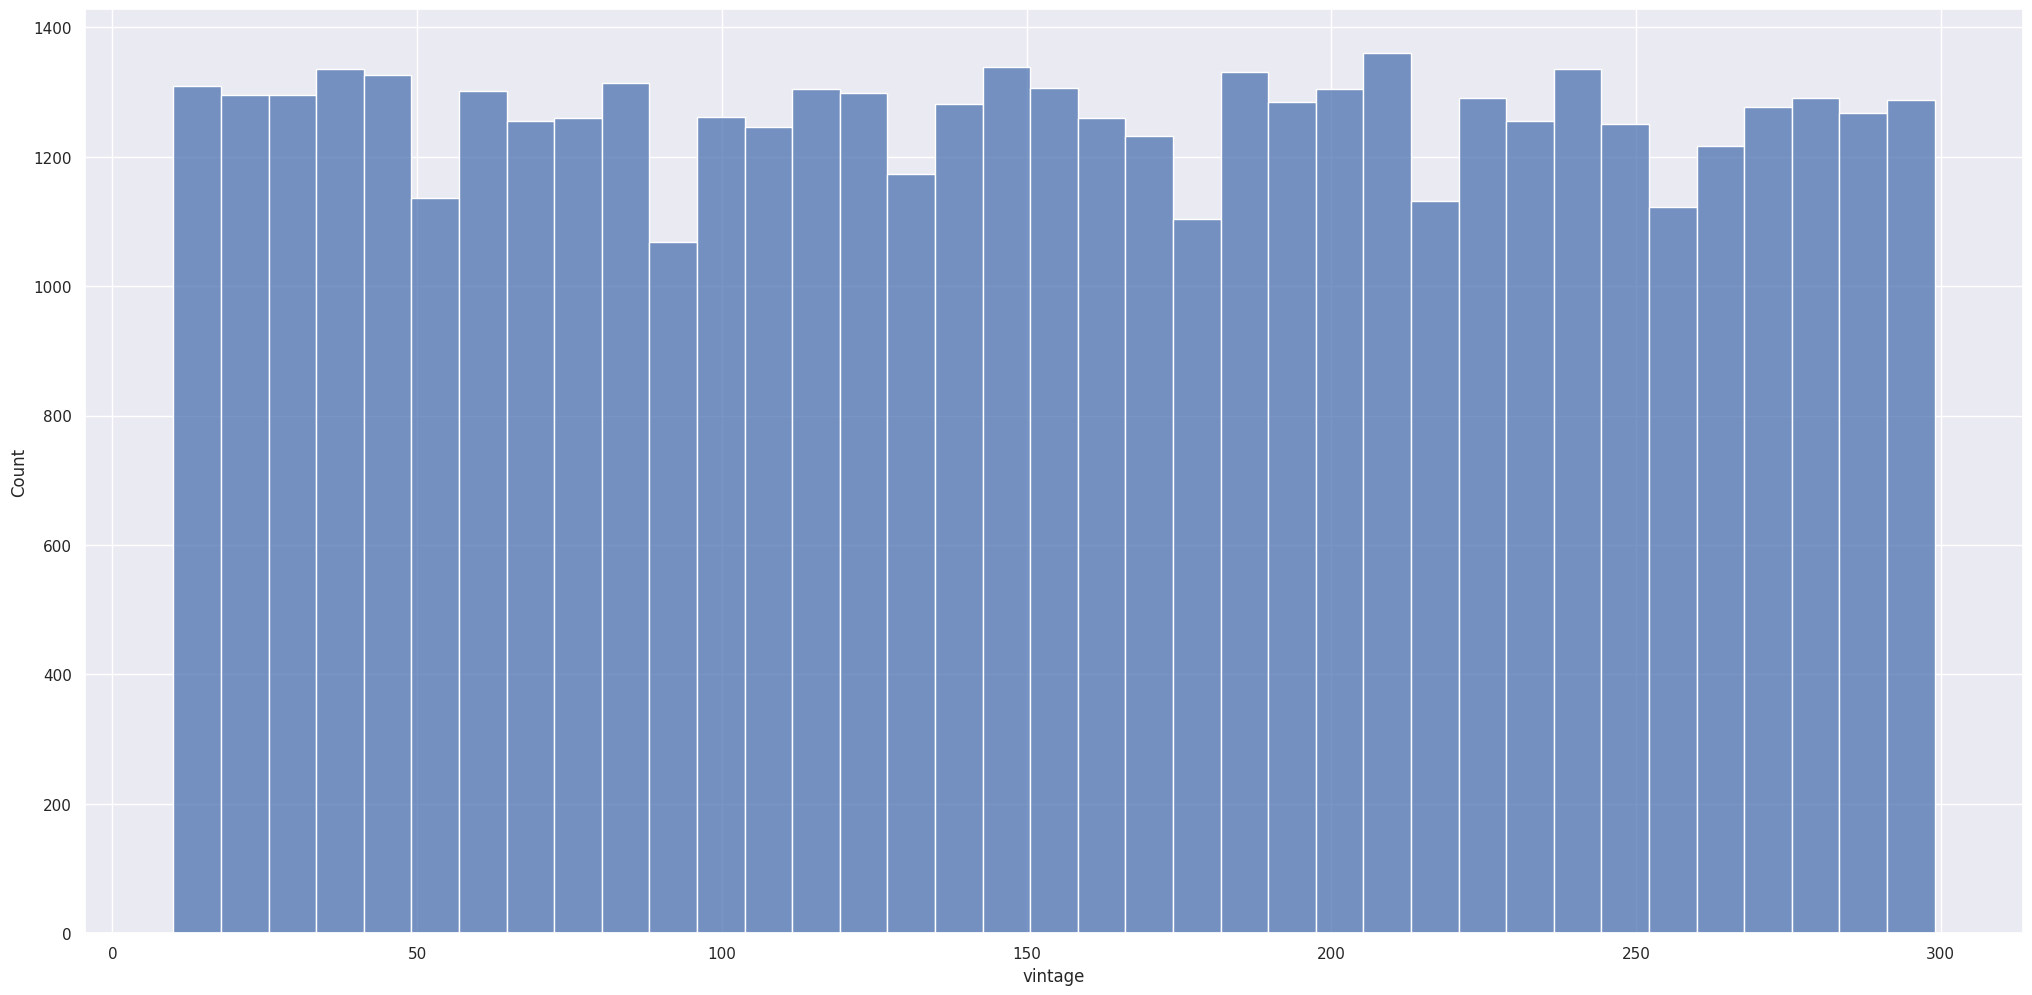

In [34]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00);

### 4.1.9. Gender

<Axes: xlabel='gender', ylabel='response'>

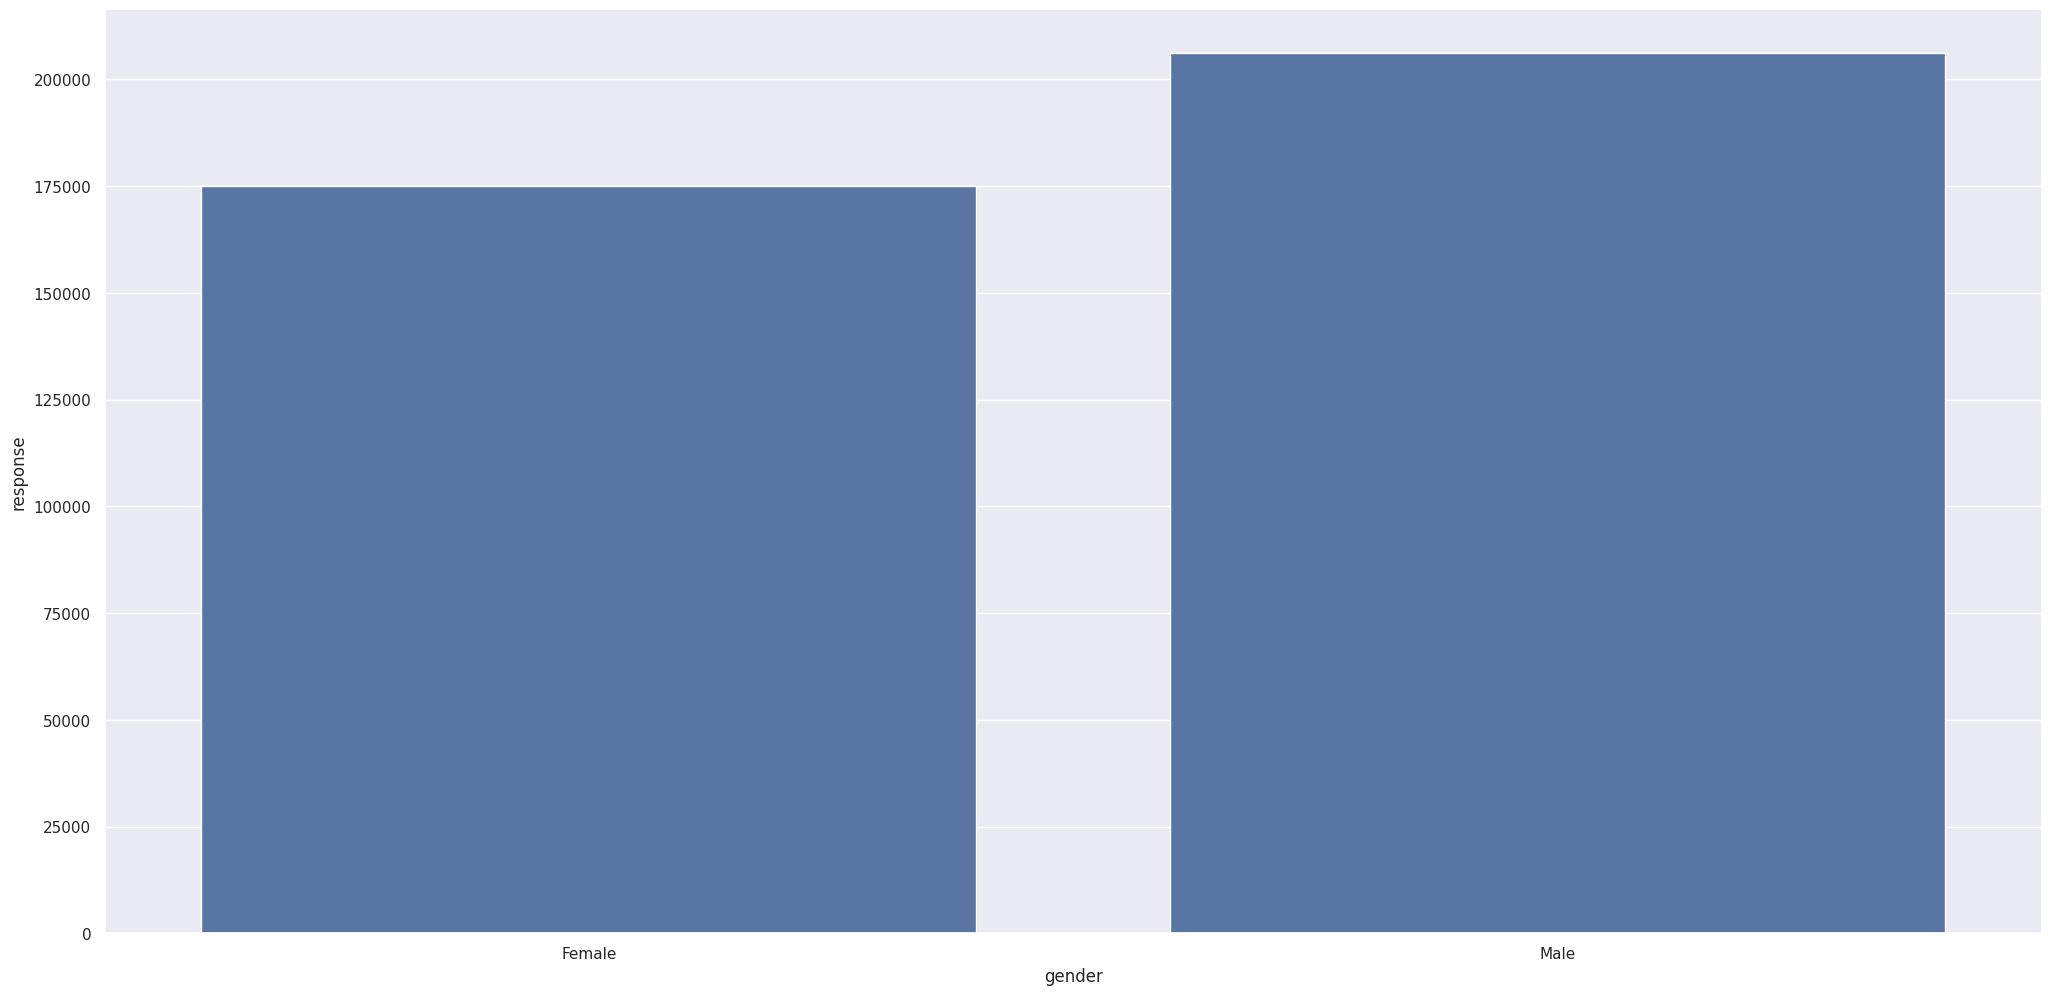

In [35]:
# gender
aux = df4[['gender', 'response']].groupby( 'gender').count().reset_index()
sns.barplot( x = 'gender', y = 'response', data = aux)

### 4.1.10. Vehicle Damage

<Axes: xlabel='response', ylabel='vehicle_damage'>

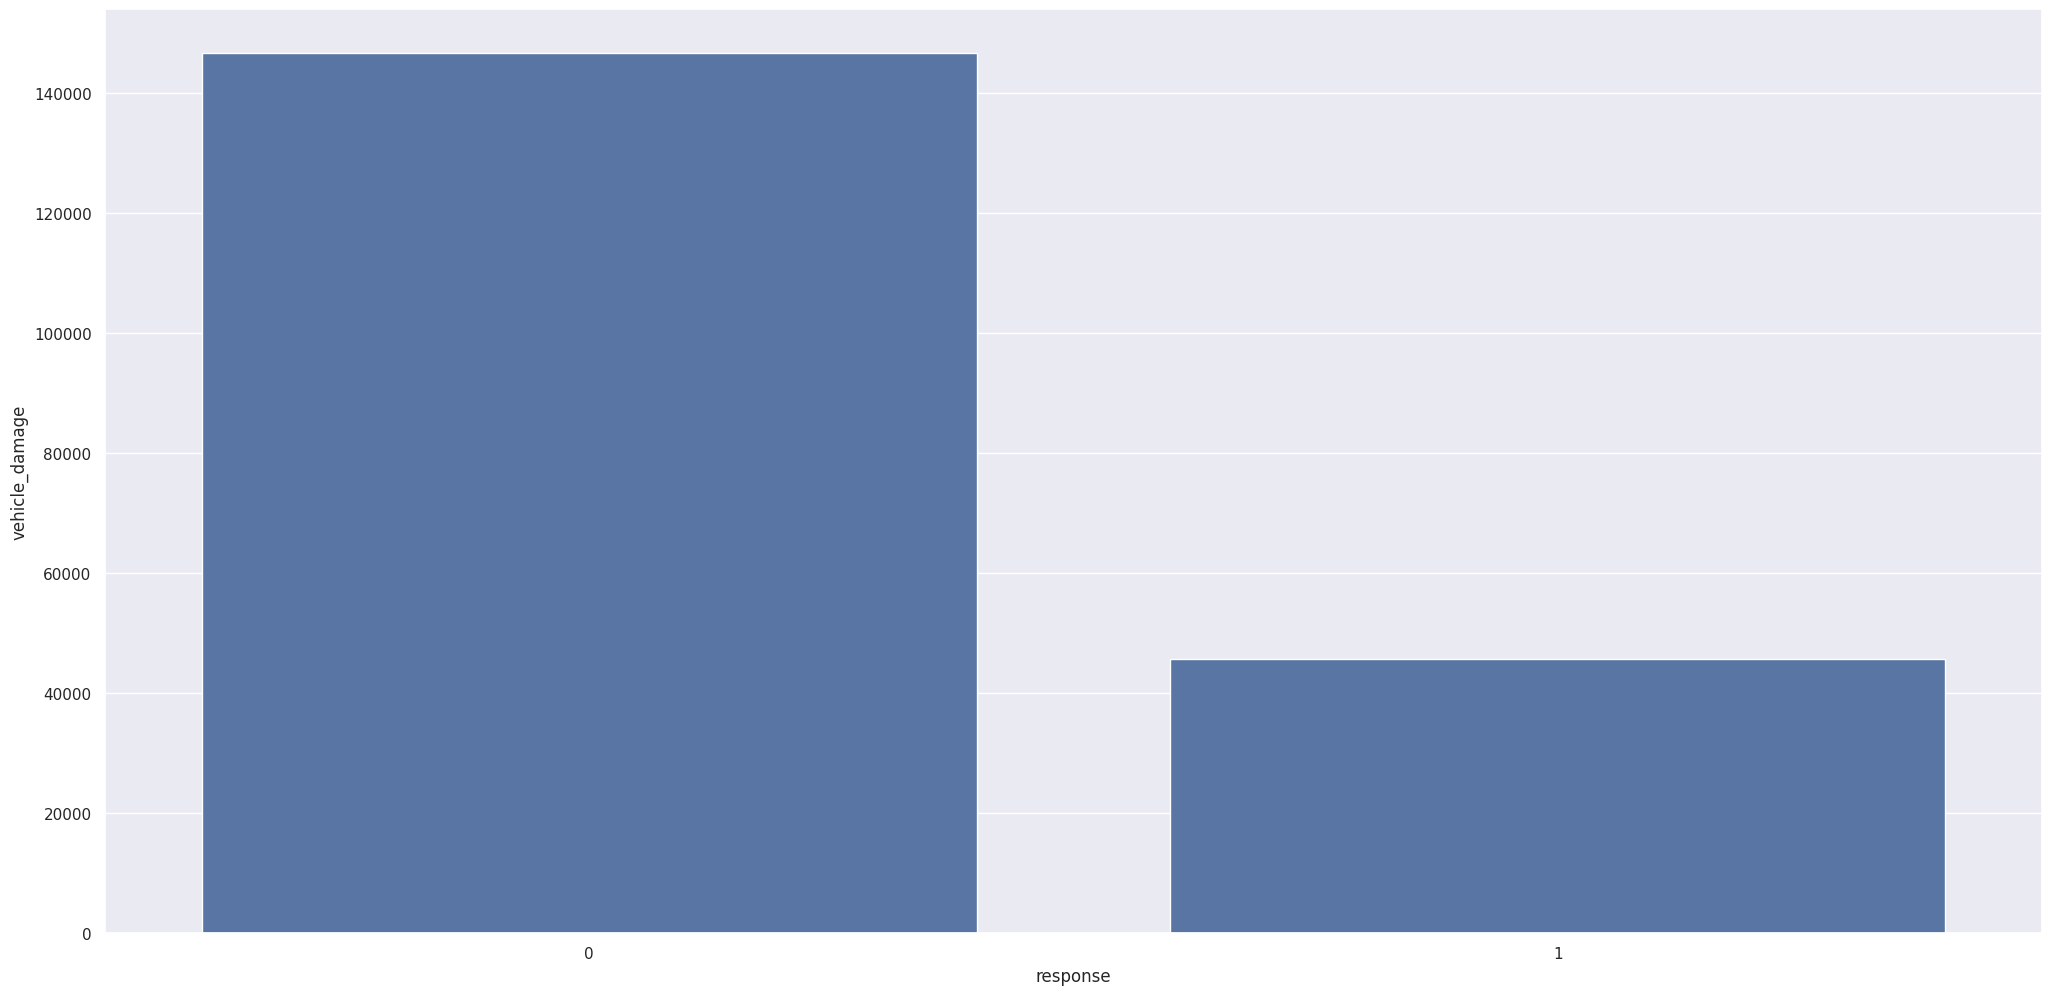

In [36]:
# vehicle_damage
aux = df4[['vehicle_damage', 'response']].groupby( 'response').sum()
sns.barplot( x = 'response', y = 'vehicle_damage', data = aux)

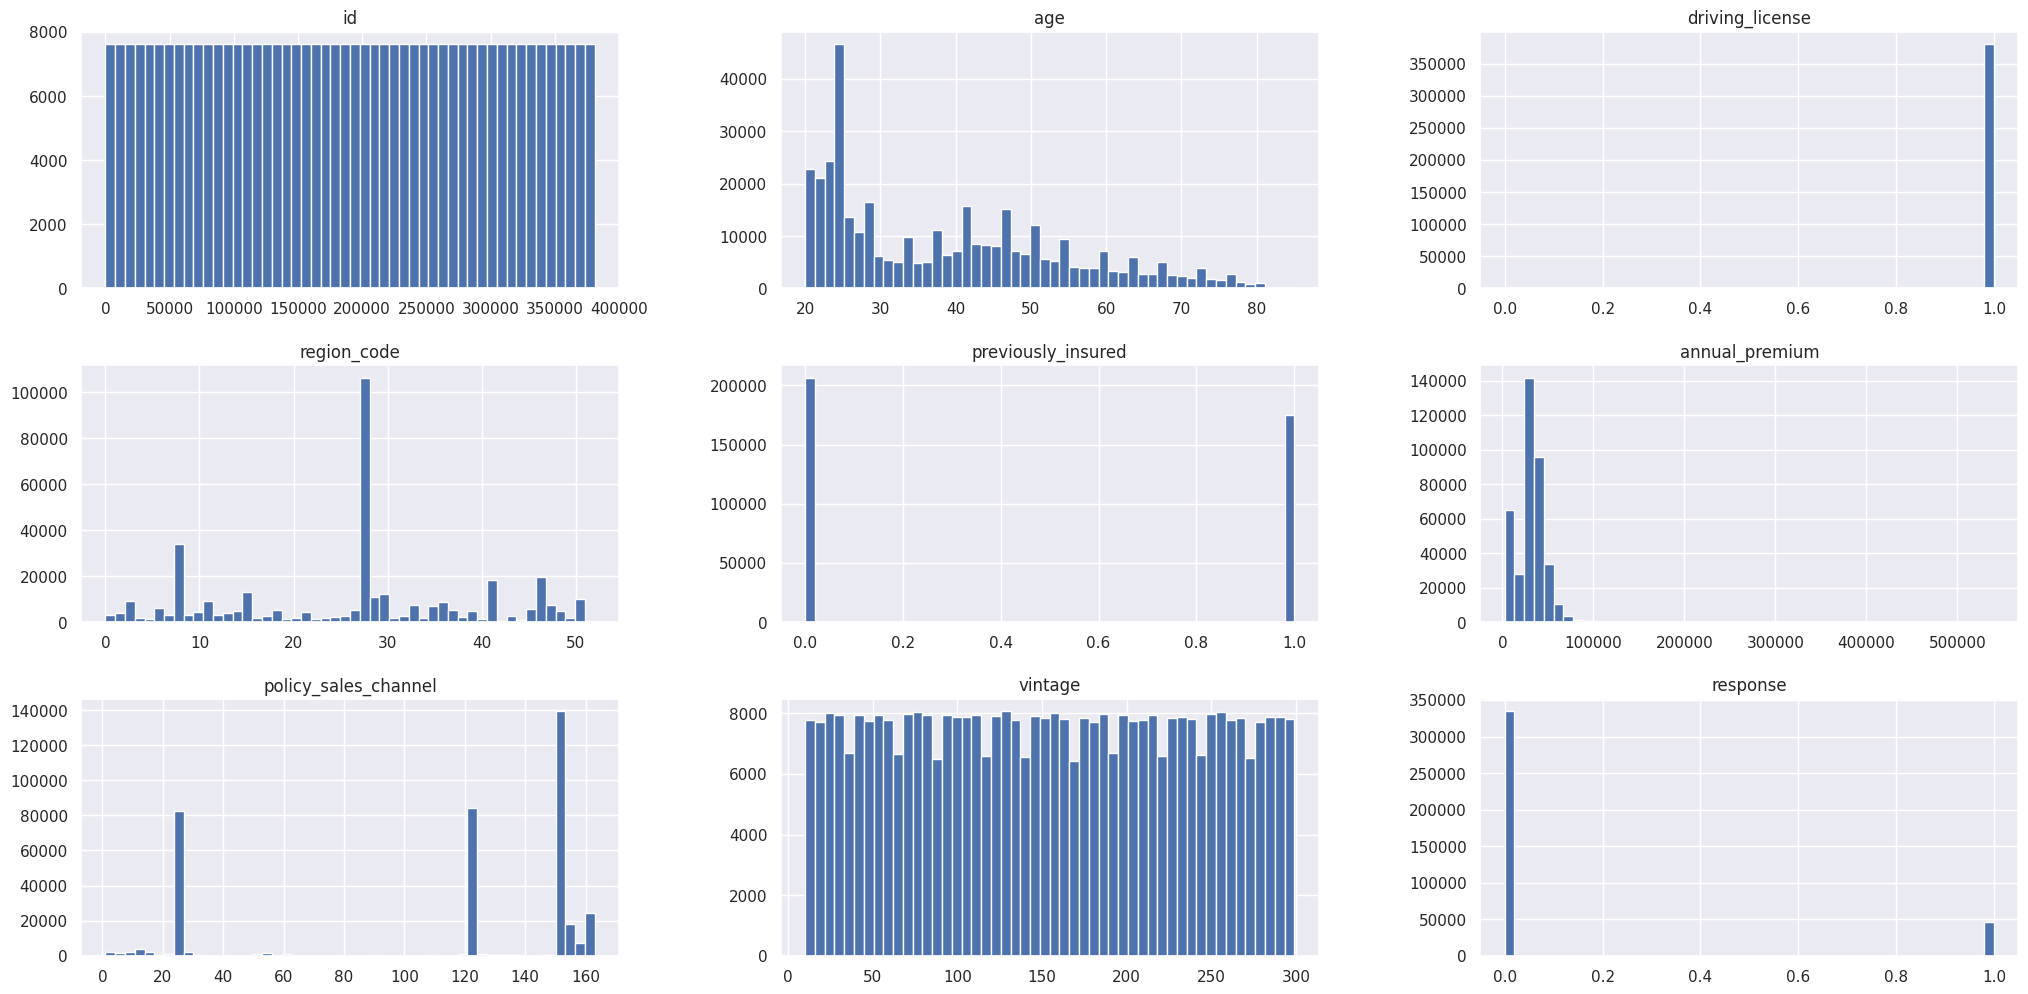

In [37]:
num_attributes.hist(bins = 50);

## 4.3. Multivariate Analysis

## 4.3.1. Numerical Attributes

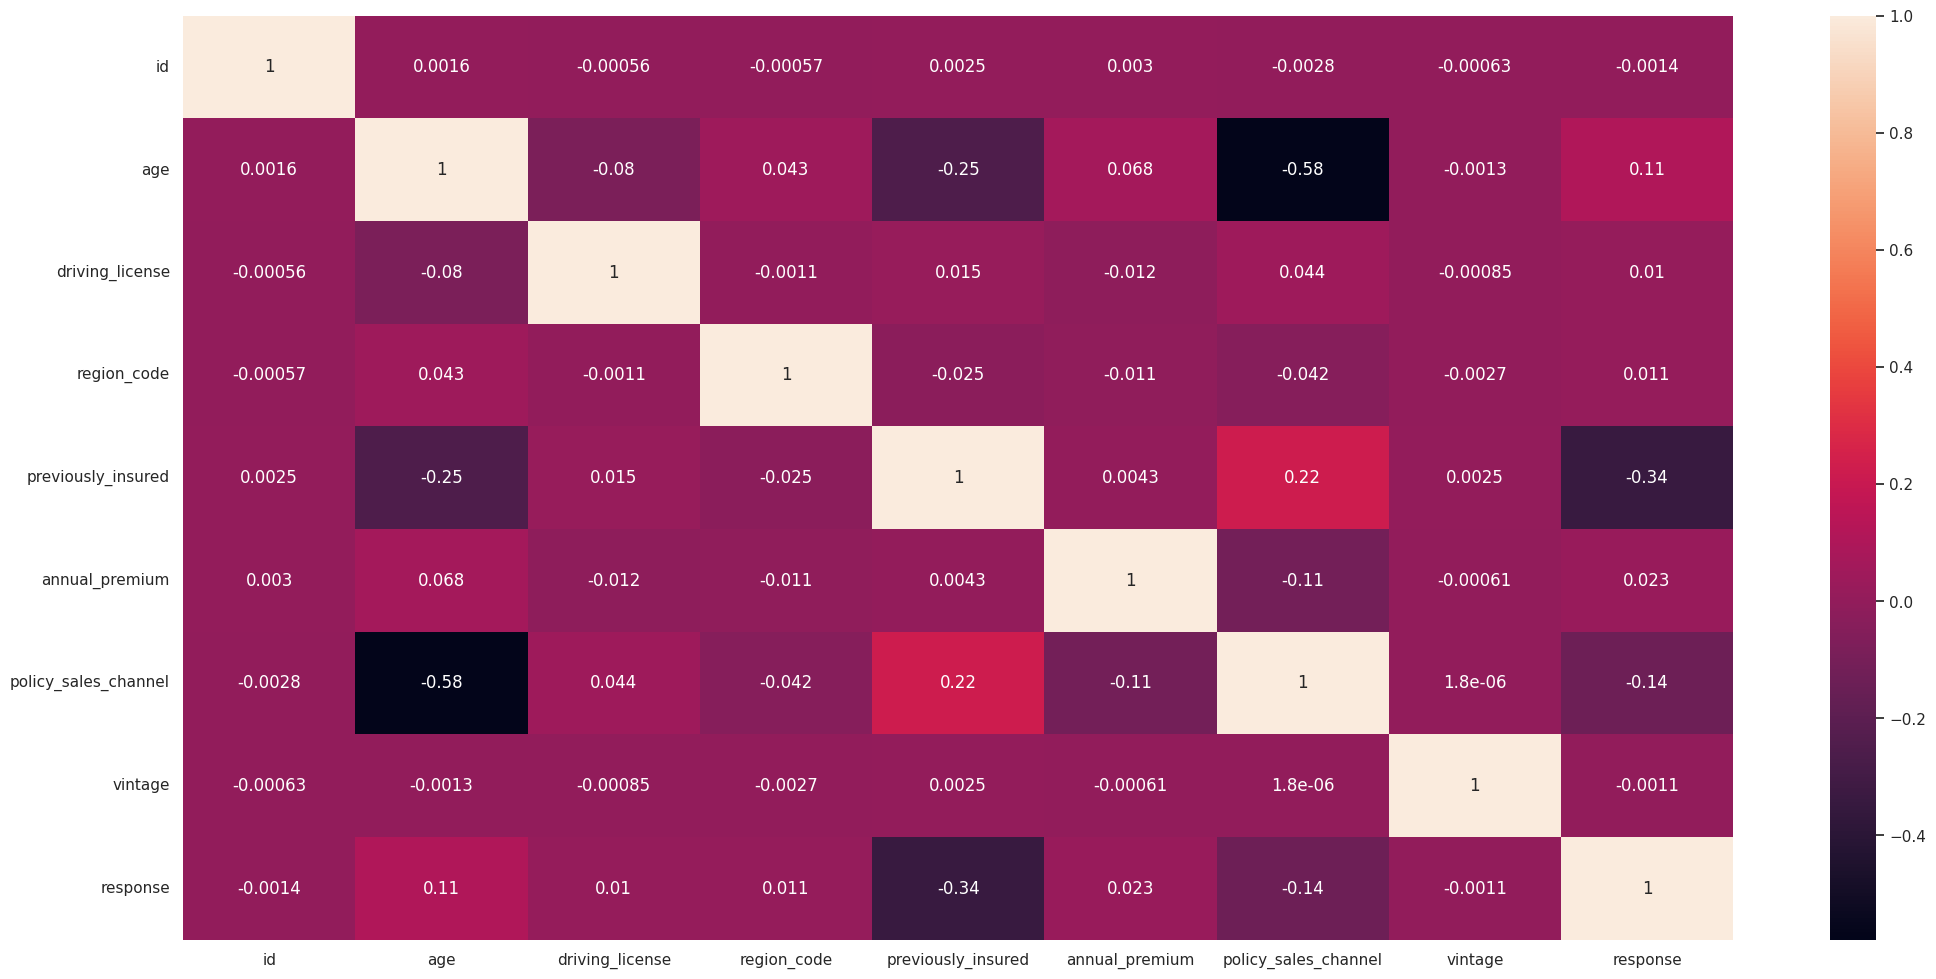

In [38]:
# Correlação das variáveis numéricas entre elas mesmas
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True );

## 4.3.2. Categorical Attributes

<Axes: >

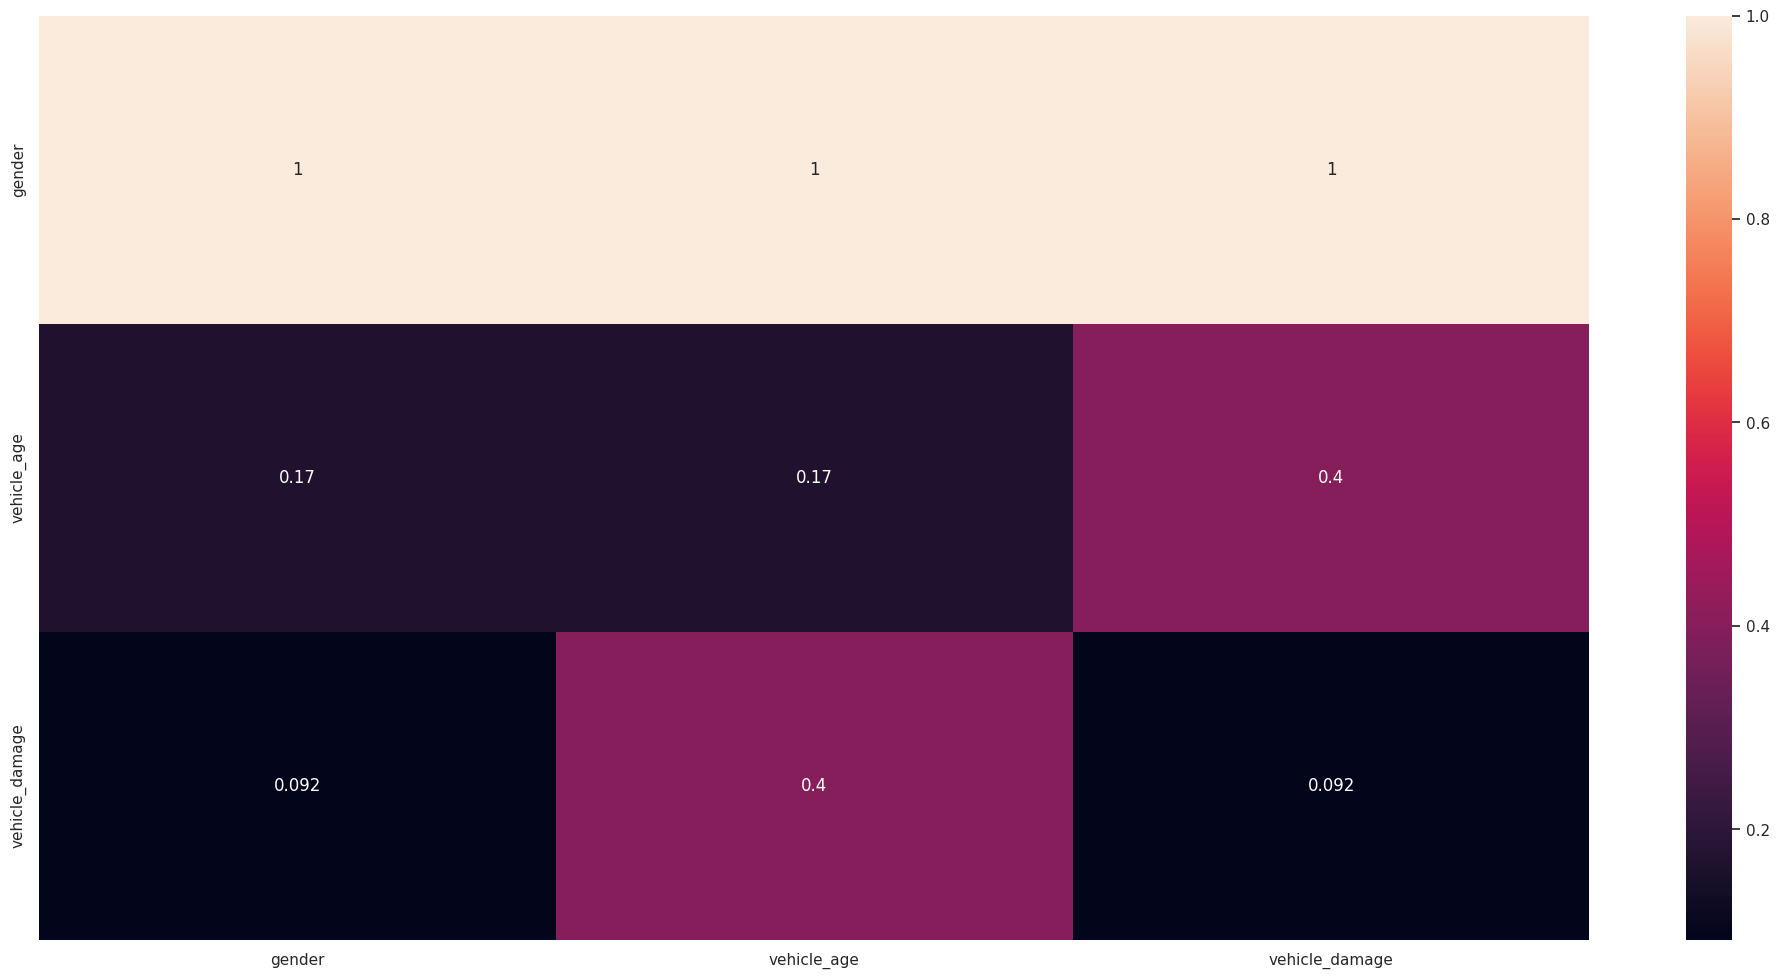

In [45]:
# Relações entre as variaveis categóricas

# Calculate cramer V
a1 = cramer_v(cat_attributes['gender'], cat_attributes['gender'] )
a2 = cramer_v(cat_attributes['gender'], cat_attributes['vehicle_age'] )
a3 = cramer_v(cat_attributes['gender'], cat_attributes['vehicle_damage'] )

a4 = cramer_v(cat_attributes['vehicle_age'], cat_attributes['vehicle_age'] )
a5 = cramer_v(cat_attributes['vehicle_age'], cat_attributes['gender'] )
a6 = cramer_v(cat_attributes['vehicle_age'], cat_attributes['vehicle_damage'] )

a7 = cramer_v(cat_attributes['vehicle_damage'], cat_attributes['vehicle_damage'] )
a8 = cramer_v(cat_attributes['vehicle_damage'], cat_attributes['vehicle_age'] )
a9 = cramer_v(cat_attributes['vehicle_damage'], cat_attributes['gender'] )

# Final Data set
d = pd.DataFrame( {'gender': [a1, a2, a3],
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9] } )

d = d.set_index( d.columns )

sns.heatmap( d, annot = True )

## 4.4. Análise das Hipóteses

### 4.4.1, Hipóteses Finais

***H1. Dos dois gêneros, Homens são os que mais procuram seguros para contratar.***

***H2. Pessoas mais velhas se interessam pelo seguro***

***H3. Das pessoas interessadas no seguro, a maioria tem habilitação***

***H4. Das pessoas interessadas no seguro, a maioria não possuia seguro antes***

***H5. Quanto maior o valor que o cliente paga pelo prêmio anual, mais a chance dele se interessar pelo seguro***

***H6. Quanto mais tempo a pessoa possui seguro de vida, maiores as chances de aceitar um seguro veicular***

***H7. Quanto mais velho o veículo, mais chance da pessoa se interessar pelo seguro***

***H8. CLientes que já possuiram sinistros no passado possuem mais chances de querer o seguro***

### 4.4.2. H1. Dos dois gêneros, Homens são os que mais procuram seguros para contratar.

***Verdadeiro*** - Mais de 60% das pessoas que se interessam são homens

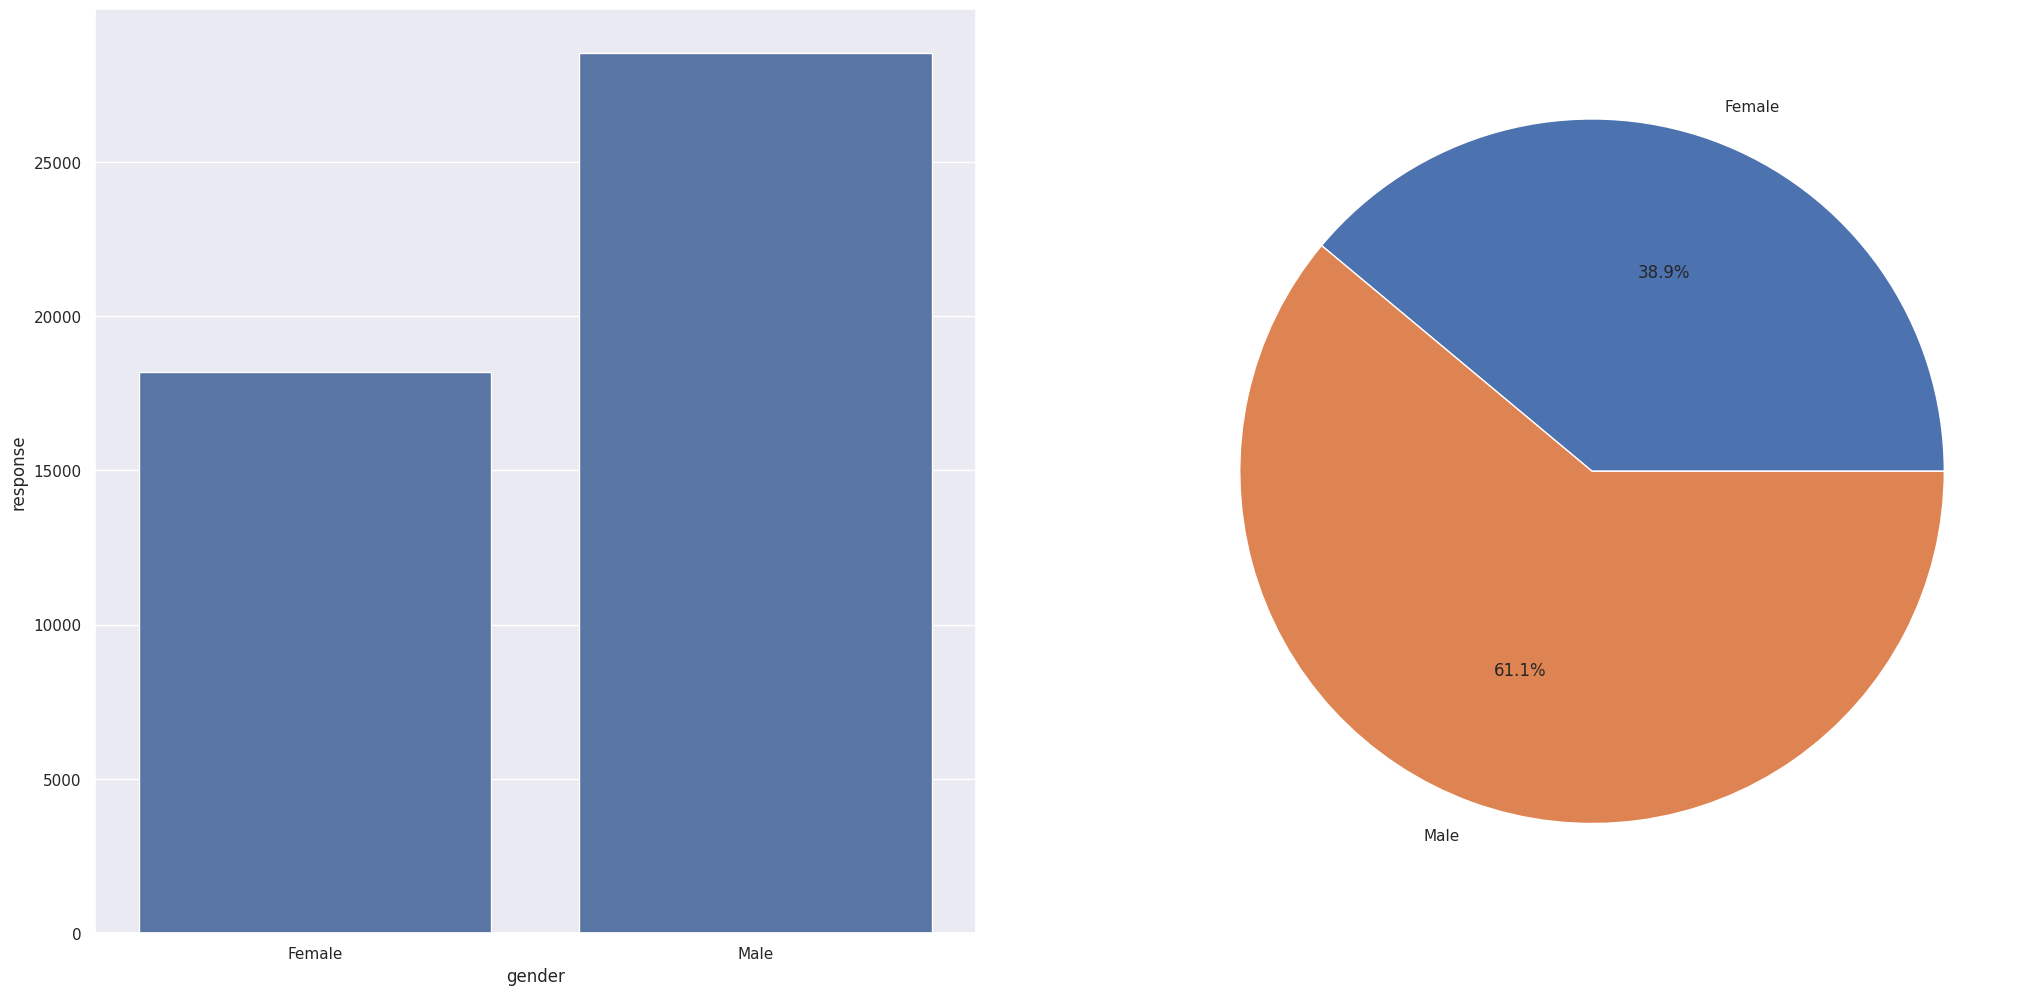

In [72]:
aux1 = df4[['gender', 'response']].groupby(['gender']).sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot( x = 'gender', y = 'response', data = aux1)

plt.subplot(1, 2, 2)
plt.pie(aux1['response'], labels=aux1['gender'], autopct='%1.1f%%');

### 4.4.3. H2. Pessoas mais velhas se interessam mais pelo seguro

***Falso*** - As pessoas mais velhas tem a tendência de se interessarem menos pelo seguro

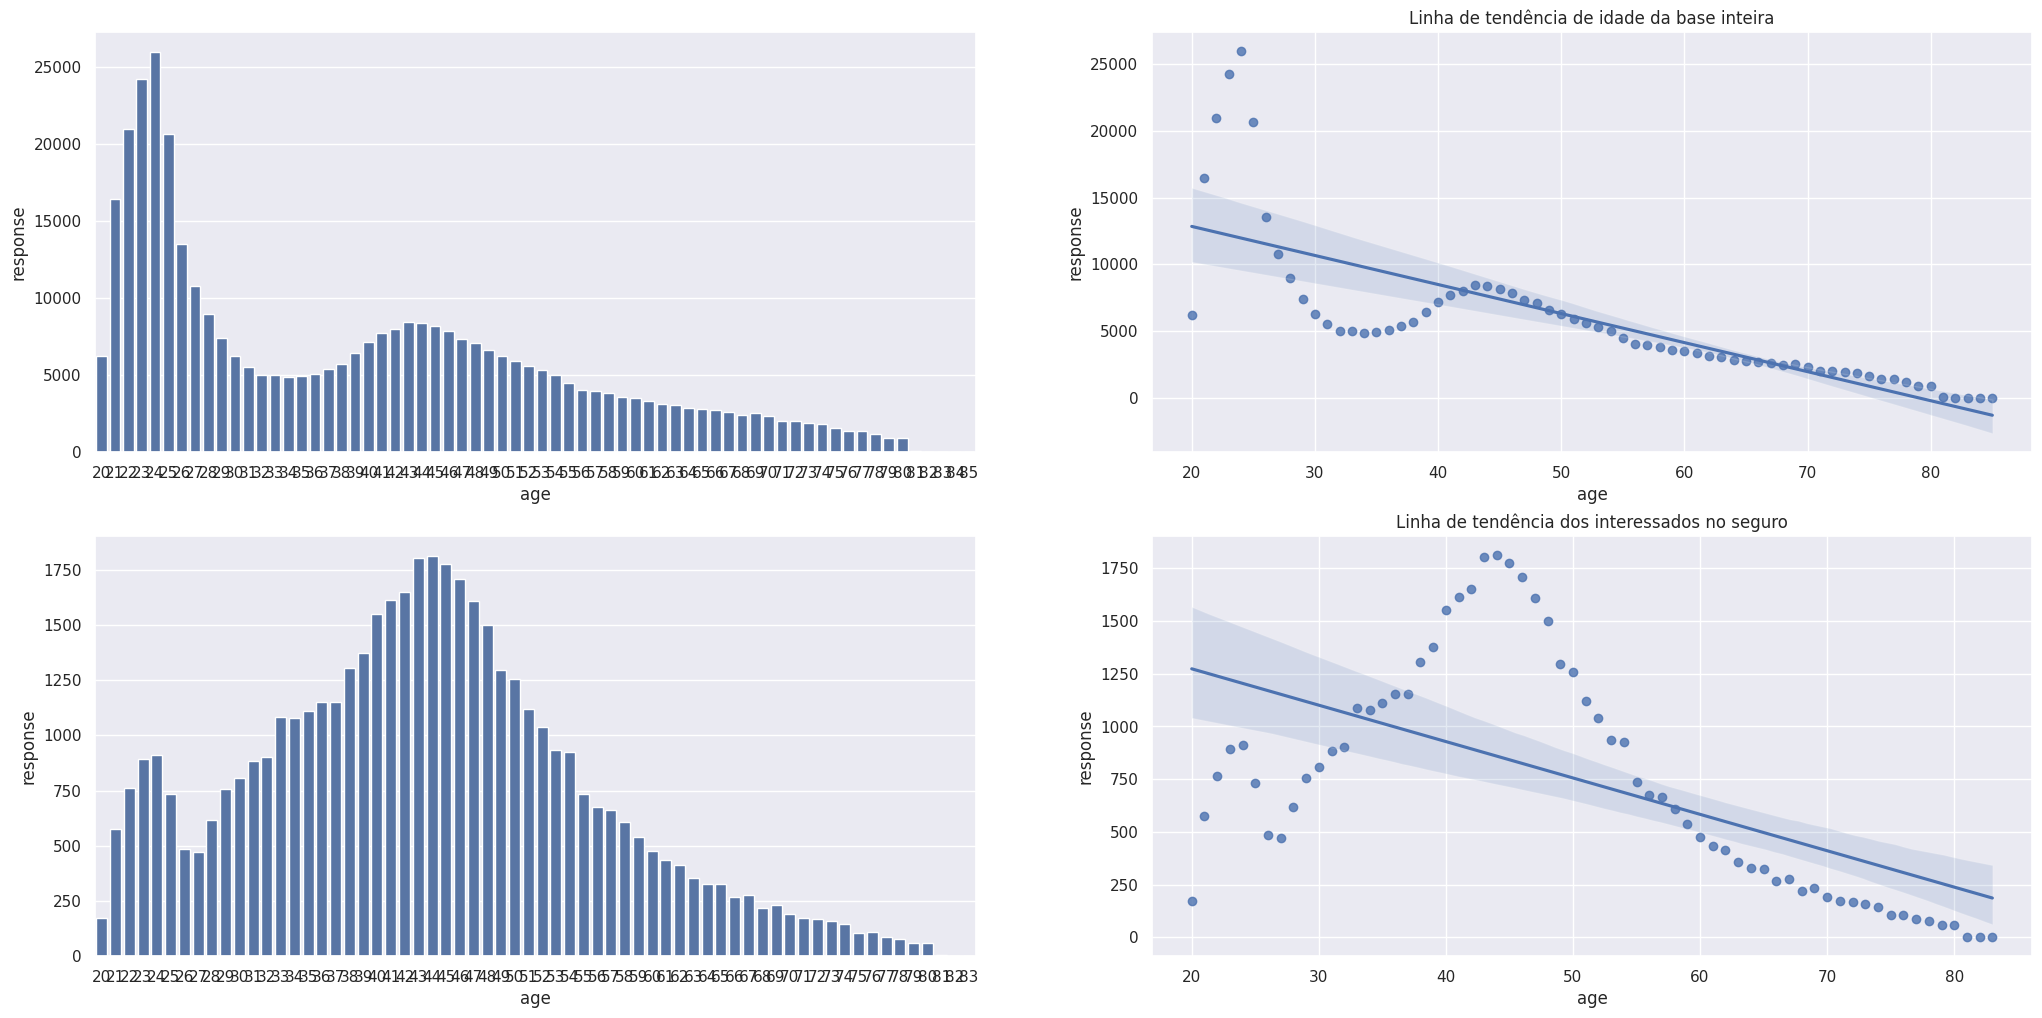

In [64]:
plt.subplot(2, 2, 1)
aux1 = df4[['age', 'response']].groupby(['age']).count().reset_index()
sns.barplot( x = 'age', y = 'response', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(y='response', x='age', data=aux1);
plt.title('Linha de tendência de idade da base inteira');

plt.subplot(2, 2, 3)
aux2 = df4.loc[(df4['response'] == 1), ['age', 'response']].groupby('age').count().reset_index()
sns.barplot( x = 'age', y = 'response', data = aux2)

plt.subplot(2, 2, 4)
sns.regplot(y='response', x='age', data=aux2);
plt.title('Linha de tendência dos interessados no seguro');

### 4.4.4. H3. Das pessoas interessadas no seguro, a maioria tem habilitação

***Verdadeiro*** - A maioria das pessoas que se interessam pelo seguro possuem habilitação

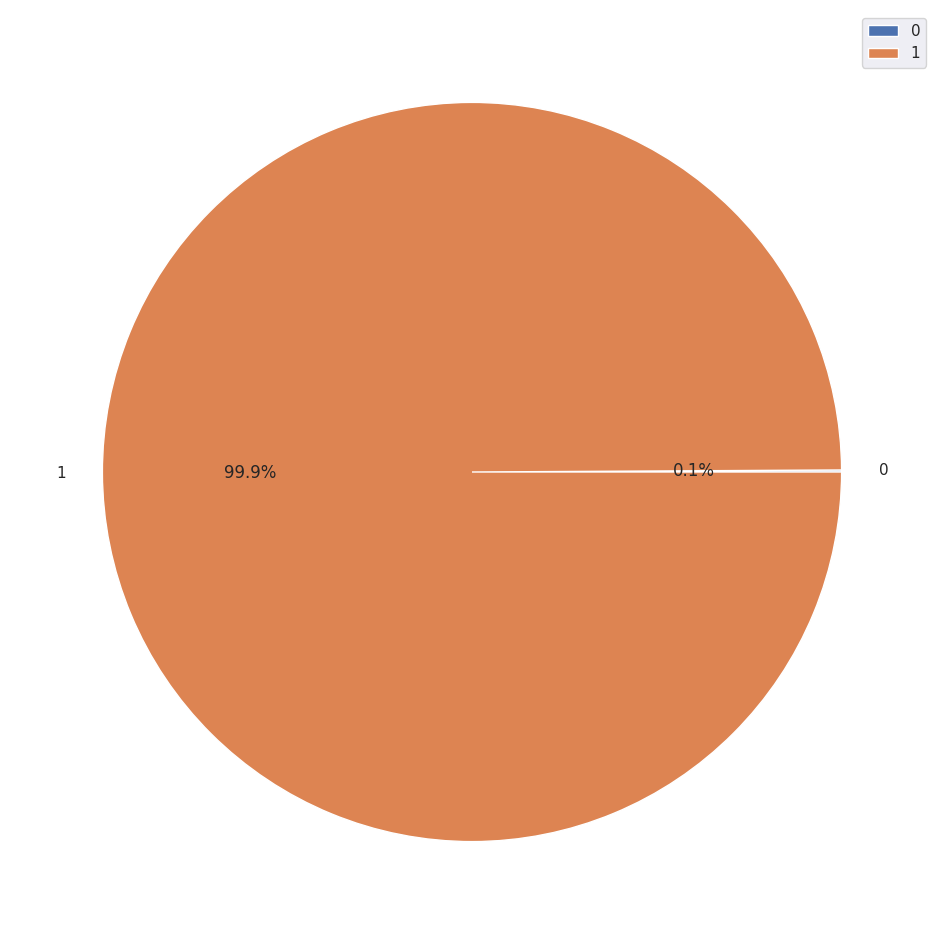

In [73]:
aux1 = df4.loc[(df4['response'] == 1), ['driving_license', 'response']].groupby('driving_license').count().reset_index()
plt.pie(aux1['response'], labels=aux1['driving_license'], autopct='%1.1f%%');
plt.legend()

In [46]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


# 5.0. Data Preparation

In [36]:
df5 = df4.copy()

In [37]:
# Separação dos dados em teste e validação
# Nesse caso como o vazamento é pequeno não se preocupar com separação aqui ou no começo

# Simulando os dados que vem em produção
X = df5.drop('response', axis = 1)

# Guardando a variavel resposta
Y = df5['response'].copy()

# Separando de forma aleatória os dados que vão para treino e os que vao para teste
x_train, x_validation, y_train, y_validation = ms.train_test_split( X,Y, test_size = 0.20 )

# Juntando os dados de treino com a variável resposta do treino
df5 = pd.concat( [x_train, y_train], axis = 1)

## 5.1. Standardization

In [38]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values) # Separação em array para poder funcionar

## 5.2. Rescaling

In [39]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - Distribuição longe da normal
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Encoder

In [40]:
#Para descobrir o melhor encoding tem que testar (One Hot Enconding / Frequency Encoding / Target Encoding / Weighted Target Encoding)
#Label Encoding - 0 ou 1
#One Hot Encoding - Indica um estado

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
# Tem muitas categorias, mais de 6, não usa o One Hot Encoding, aumentaria muito a dimensionalidade do dataset
target_encode_region_code = df5.groupby( 'region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code ) # As linhas recebem os valores

# vehicle_age - ONe Hot Encoding/ Order Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix = 'vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5) #Quantos elementos eu tenho em cada grupo sobre a quantidade total
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel)

# gender - One Hot Encoding / Targe t Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

## 5.4 Validation Preparation

In [41]:
#Utilizando os encoders usados no treino na validação

#gender
x_validation.loc[:,'gender'] = x_validation['gender'].map(target_encode_gender)

#age
x_validation['age'] = mms_age.fit_transform(x_validation[['age']].values)

#region_code
x_validation.loc[:,'region_code'] = x_validation['region_code'].map(target_encode_region_code)

#vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age',columns=['vehicle_age'])

#annual_premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

#policy_sales_channel
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

#vintage
x_validation['vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)

# 6.0. Data Preparation

## 6.1 Boruta

In [42]:
#Definindo os datasets para o Boruta
#X_train_n = df5.drop(['response'],axis=1).values
#Y_train_n = y_train.values.ravel()

#Definindo o RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Definindo o Boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,Y_train_n)

In [43]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = df5.drop(['response'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Colunas não selecianadas pelo boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [44]:
#cols_selected_boruta

## 6.2. Features Importance

In [45]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators = 80, random_state = 0, n_jobs = -1 ) # correto seria utilizar n_estimators = 250, porém falta de memória

# data preparation
x_train_n = df5.drop( ['id', 'response' ], axis = 1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train )

ExtraTreesClassifier(n_estimators=80, n_jobs=-1, random_state=0)

Feature Ranking
                         feature  importance
0                        vintage    0.271747
0                 annual_premium    0.244501
0                            age    0.162600
0                    region_code    0.109023
0                 vehicle_damage    0.066337
0             previously_insured    0.058475
0           policy_sales_channel    0.057938
0       vehicle_age_below_1_year    0.013885
0  vehicle_age_between_1_2_years    0.007082
0                         gender    0.005285
0       vehicle_age_over_2_years    0.002616
0                driving_license    0.000511


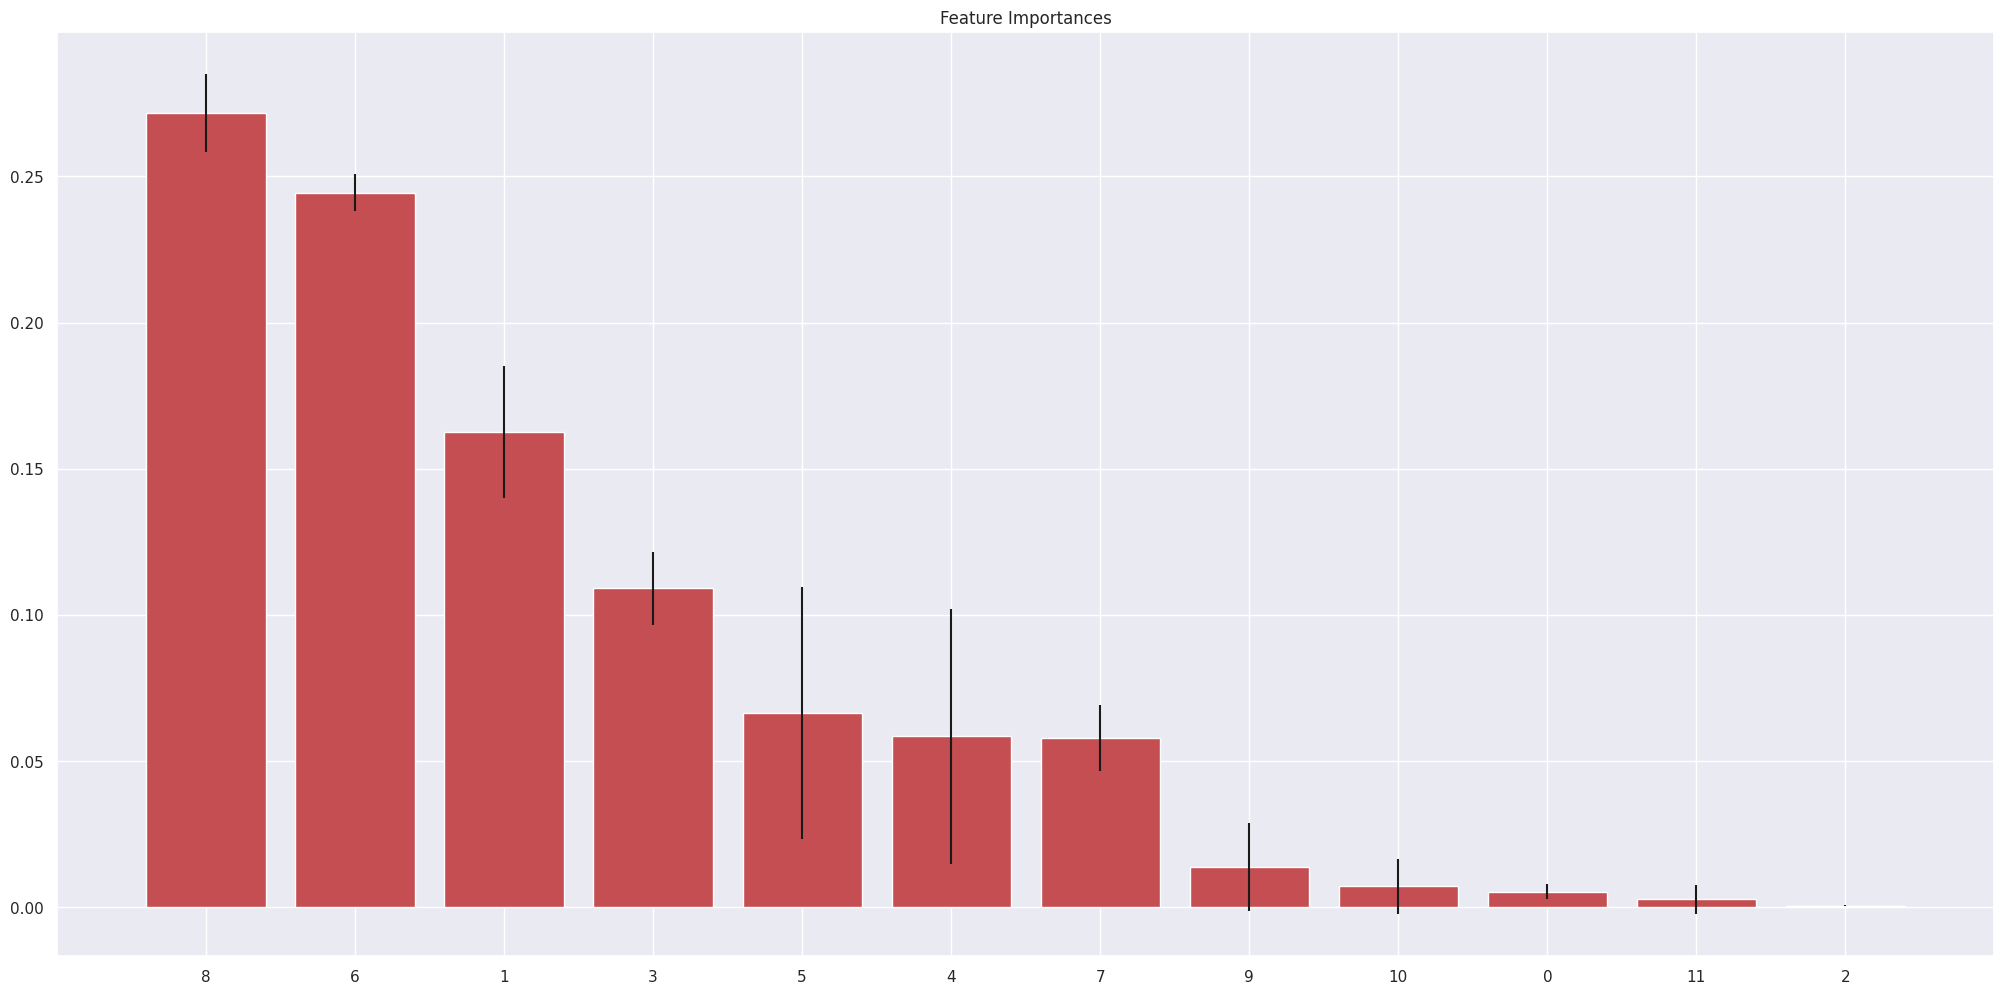

In [46]:
importances = forest.feature_importances_ # Salva as importancias das features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort( importances )[::-1] # Importâncias das árvores ordenadas pelo maior valor

# print the feature ranking
print( 'Feature Ranking' )
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({ 'feature': i, 'importance': j }, index = [0] )
    df = pd.concat([df,aux], axis = 0 )
    
print( df.sort_values('importance', ascending = False ))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar( range( x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()    

# Boruta selecionaria os dois de maior importancia, porém selecioanremos as features com importância acima de 5%. 

# 7.0. Machine Learning Model

In [47]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

#Usar apenas as features selecionadas
x_train = df5[cols_selected]
x_val = x_validation[cols_selected]

## 7.1. KNN

In [48]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

#model training
knn_model.fit(x_train,y_train)

#model predcition -Pode de generalização
yhat_knn = knn_model.predict_proba(x_val) #Predição de probabilidade

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

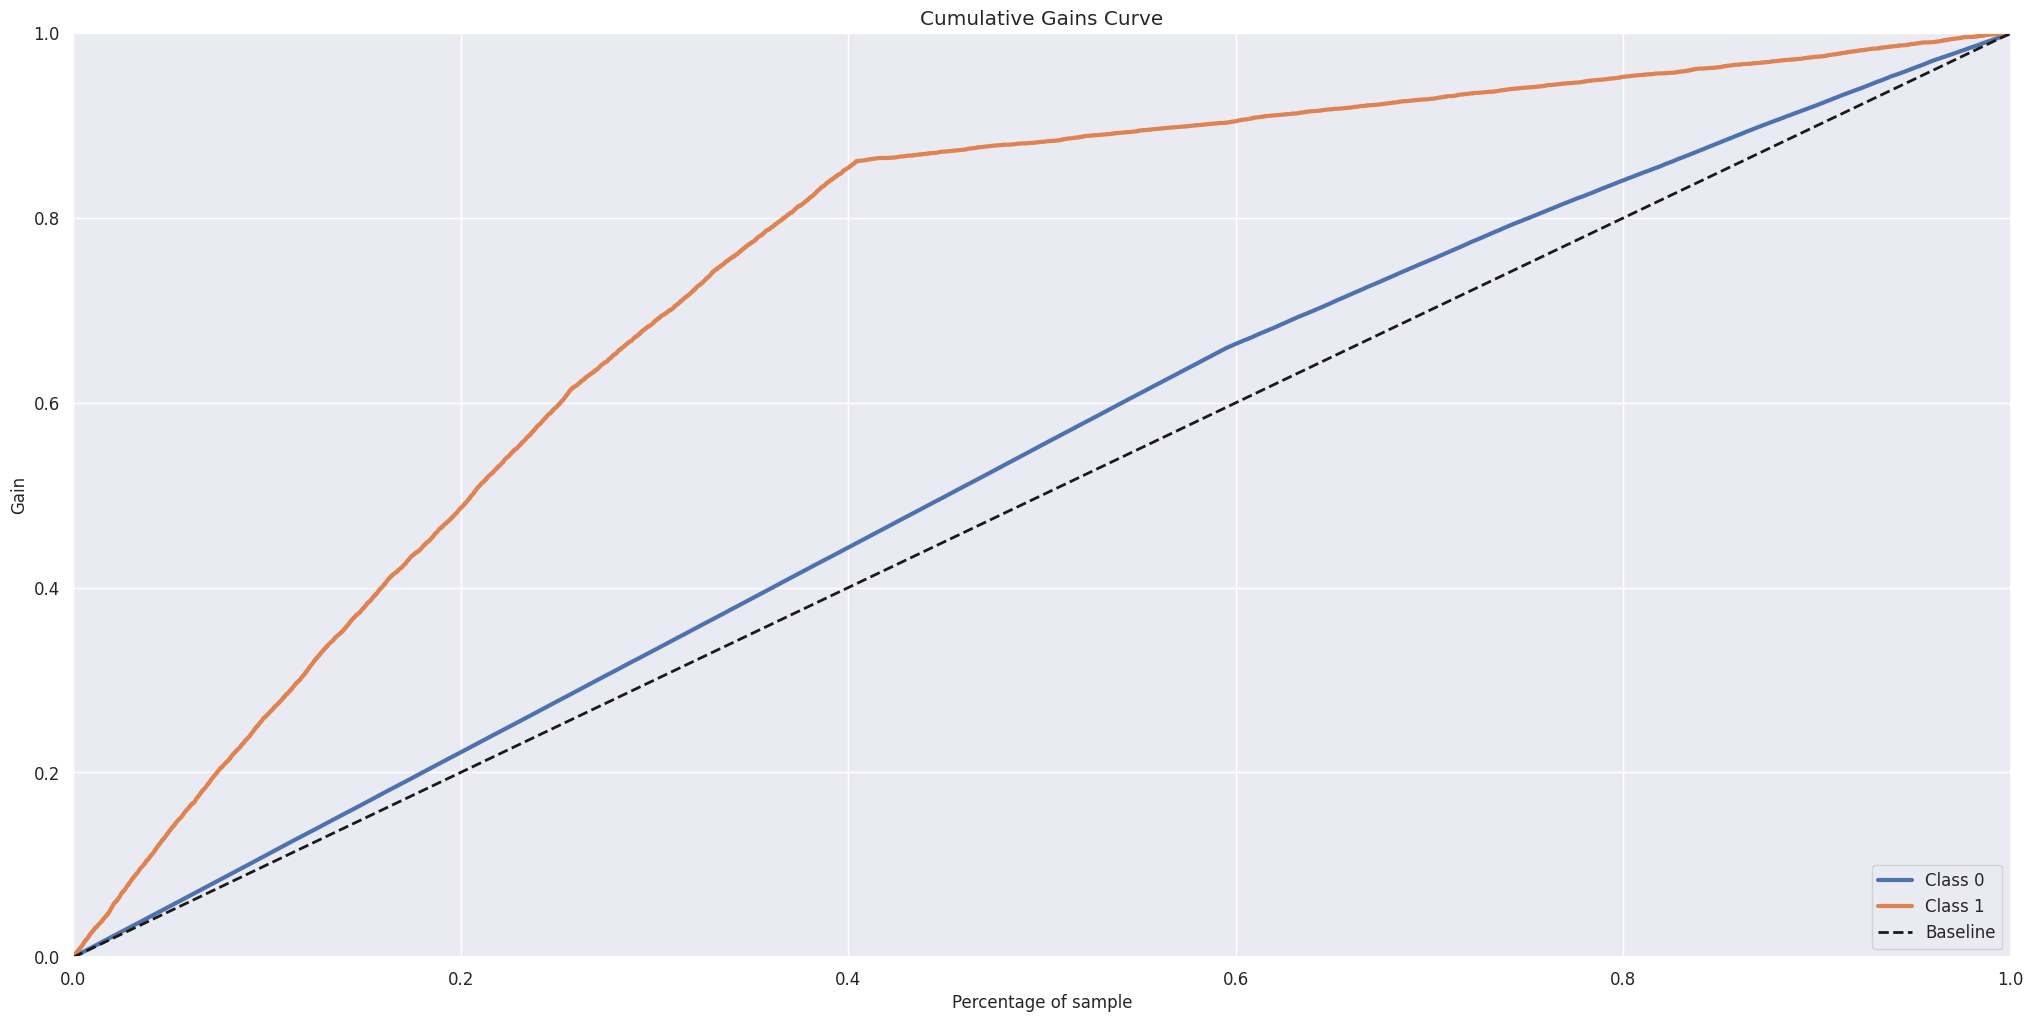

In [49]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn )

# Como o modelo vai ordenar e não classificar, usaremos as métricas de ordenação
# Estamos interessados em quão bom o modelo ordena a lista, ou seja, a menor porcentagem de amostra para o maior ganho
# # O objetivo da linha laranja é atingir o máximo de gnho com a menor quantidade de porcdntagem da amostra


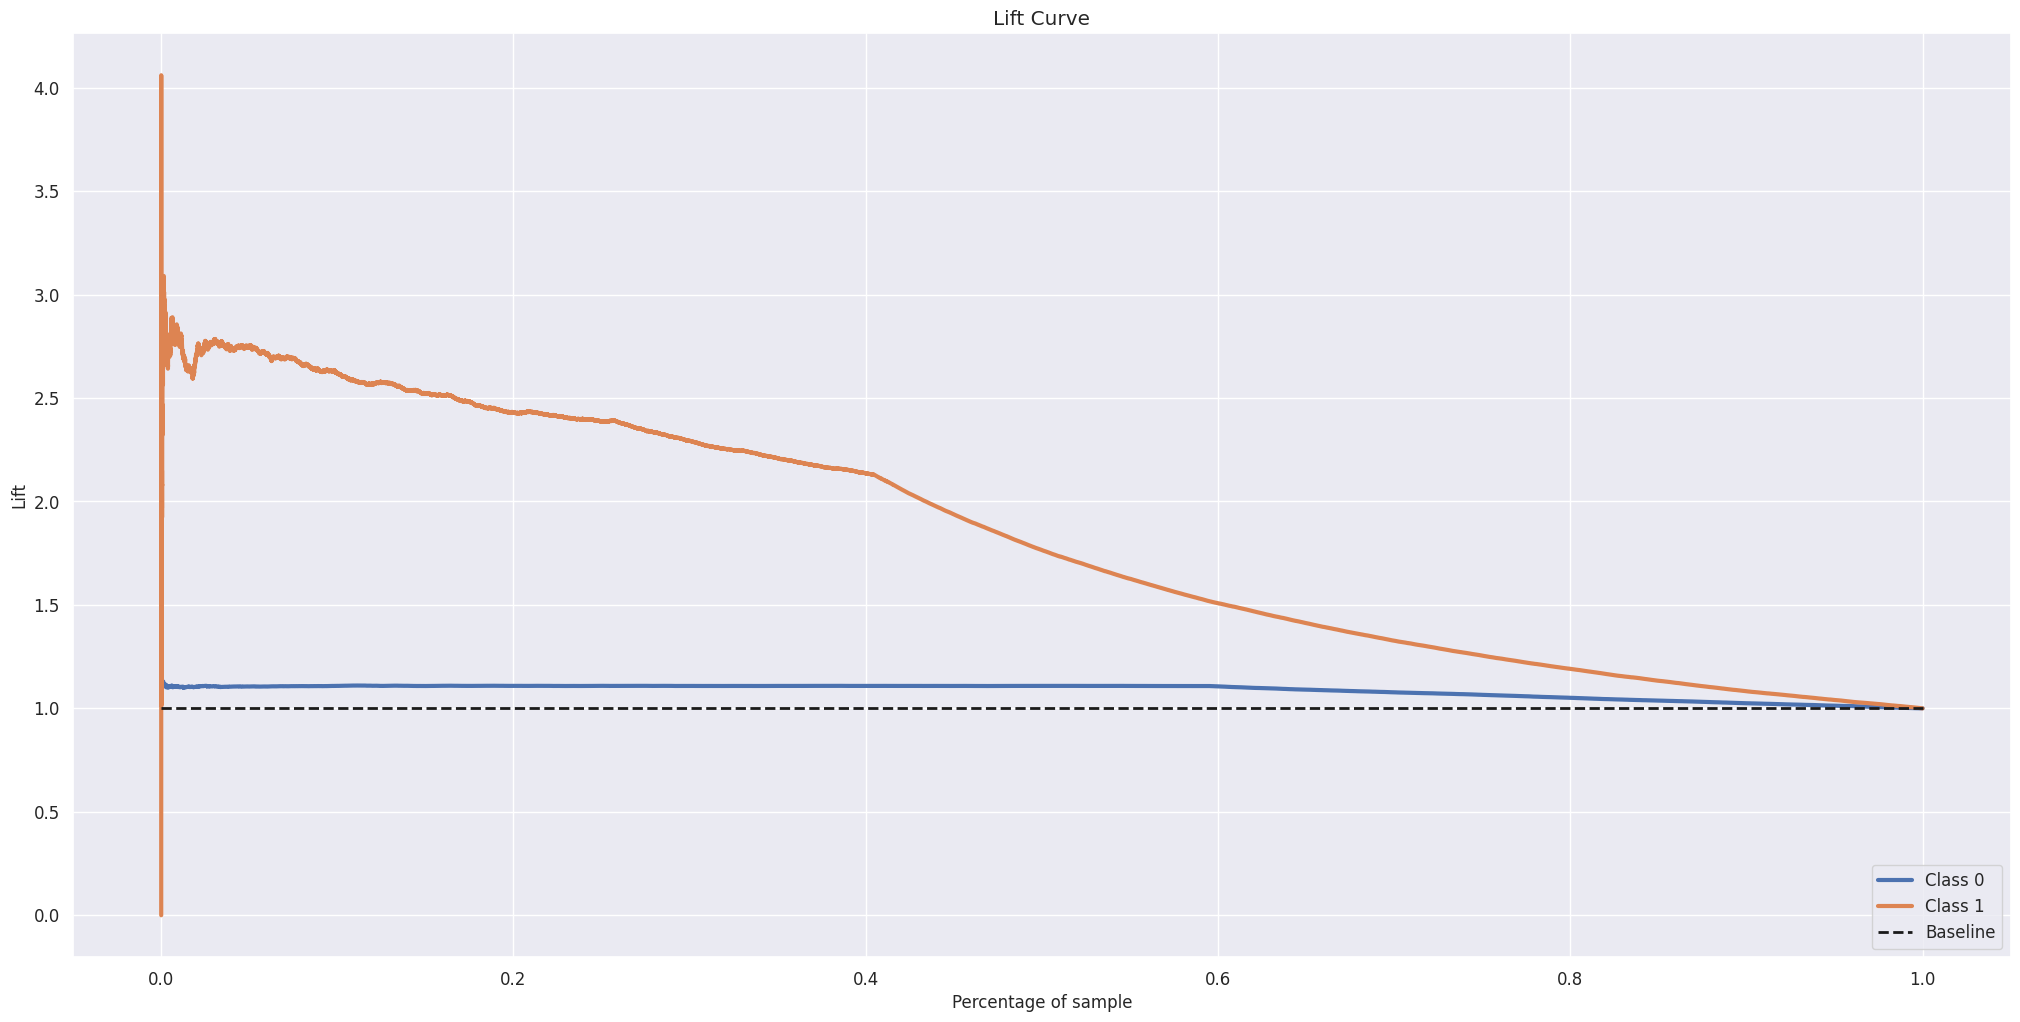

In [50]:
skplt.metrics.plot_lift_curve(y_validation,yhat_knn);

In [51]:
#df_knn = cross_validation(knn_model,x_train,y_train,5,Verbose=True)
#df_knn

## 7.2. Logistic Regression

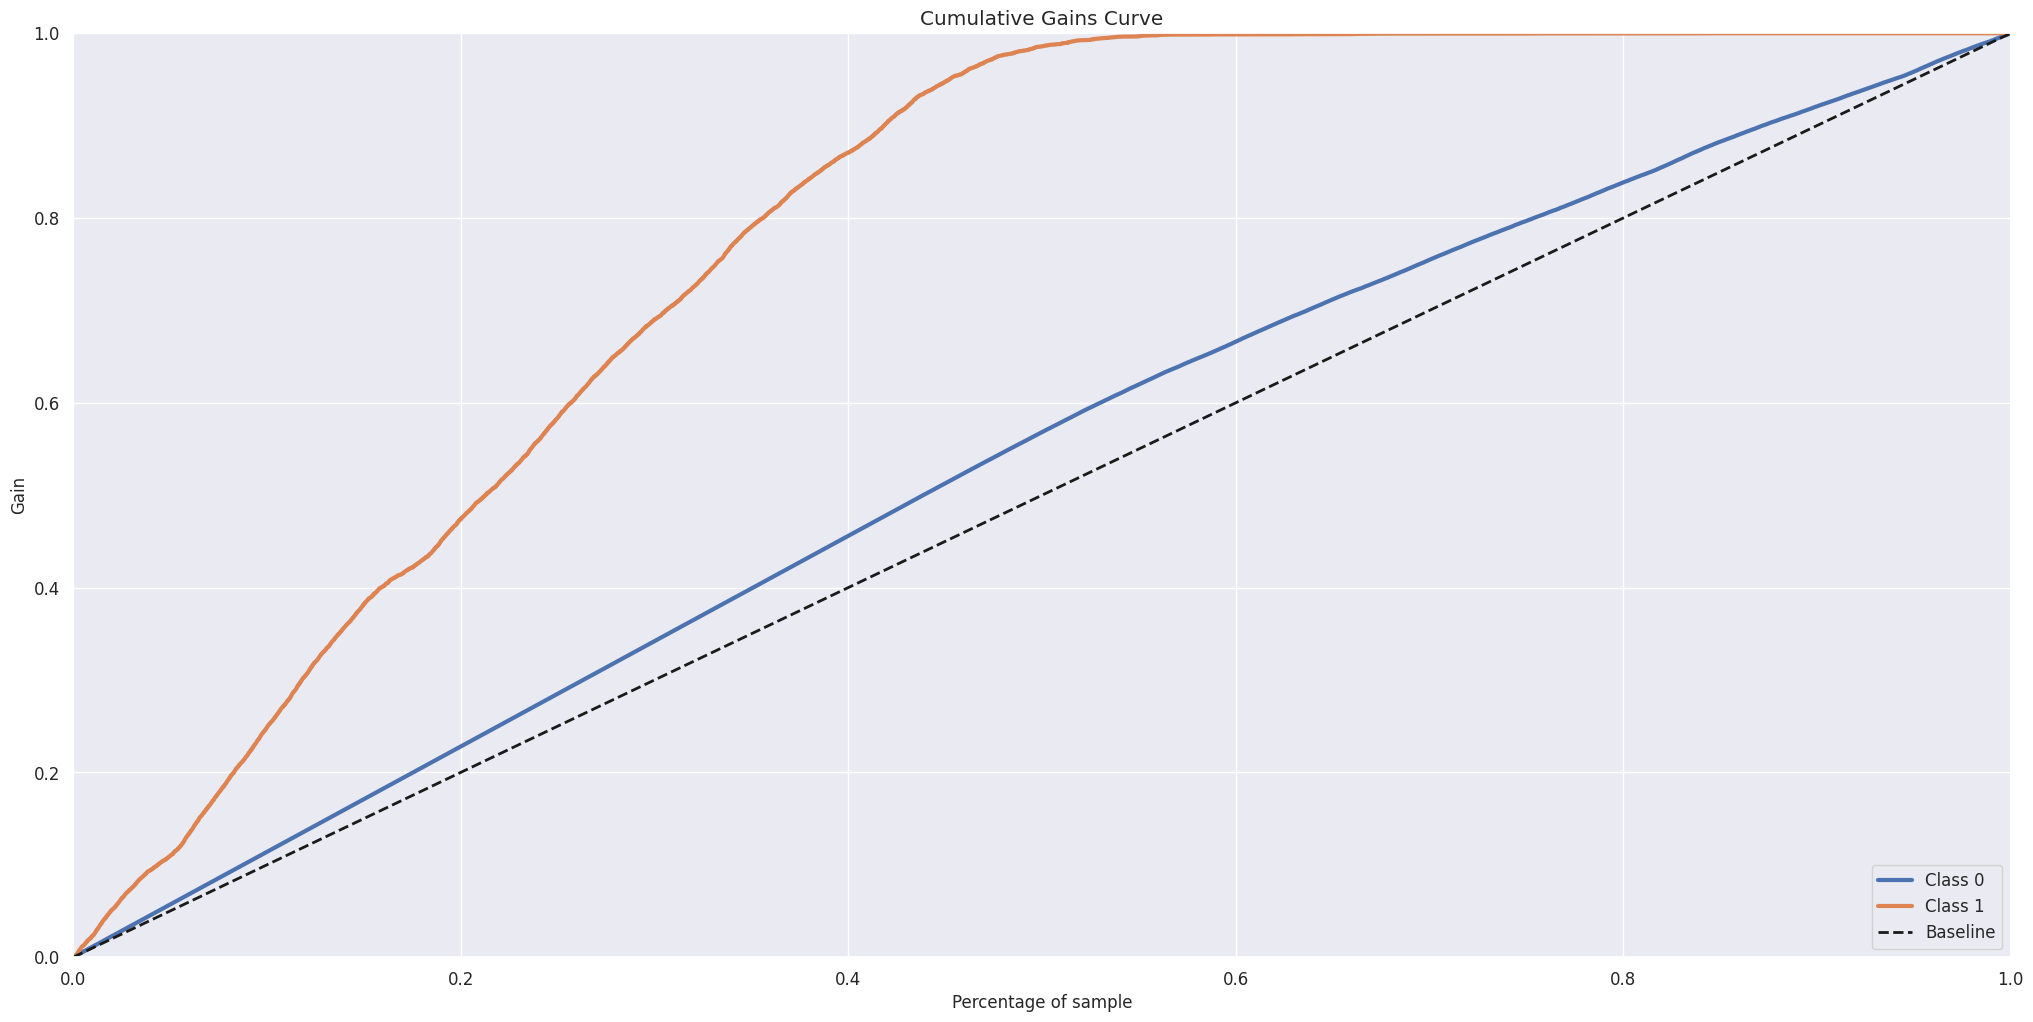

In [52]:
#model definition
lr_model = lm.LogisticRegression(random_state=42)

#model training
lr_model.fit(x_train,y_train)

#model prediction
yhat_lr = lr_model.predict_proba(x_val)

#Acumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr);

#Na logistic regression eu consigo ter 100% de pessoas interessadas com apenas 50% de sample, diferente do KNN que preciso atingir 100%

In [53]:
# df_knn = cross_validation(knn_model,x_train,y_train,5,Verbose=True)
# df_knn

## 7.3. Extra Trees

## 7.4. Random Forest

## 7.5. XGBoost

## 7.6. Naive Bayes

## 7.7. Models Comparation